In [102]:
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 25,10;
sns.set_context('poster',font_scale=1.4);
import pandas as pd;
from collections import namedtuple
from pprint import pprint;
import sys;
from copy import deepcopy;
import pickle;
import pyccl as ccl
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
%reload_ext autoreload
%autoreload 2
from fisher import Fisher, FullPlot, marginalize, plot_contours

Populating the interactive namespace from numpy and matplotlib


In [103]:
cosmo = ccl.Cosmology(Omega_c=0.2666, 
                       Omega_b=0.049, 
                       h=0.6727, 
                       sigma8=0.831, 
                       n_s=0.9645, 
                       transfer_function='eisenstein_hu')
obj = Fisher(cosmo)


In [116]:
obj._makeSourcePZ(False)
no_outliers = obj.dNdz_dict_source
obj._makeSourcePZ(True)

/global/u2/h/husni/PZ_Project/fisher.py:475: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  qo = quad(fo, 0, 4)[0]
/global/u2/h/husni/PZ_Project/fisher.py:475: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpos

In [12]:
np.exp(kde.score_samples(np.array(self.zmid).reshape(-1, 1)))

KernelDensity(bandwidth=0.2)

In [109]:
Core??

Init signature: Core(zp_support, zbias, sigma_z)
Source:        
class Core(object):
    """Defines the core and outlier population
    """
    def __init__(self, zp_support, zbias, sigma_z):
        self.zp_support = zp_support
        self.core = PhotoZ_core(zp_support, zbias, sigma_z)

    def get_pdf_given(self, z: Number):
        core_pdf = self.core.get_pdf_given(z)
        return core_pdf/np.trapz(core_pdf, self.zp_support)
File:           /global/u2/h/husni/PZ_Project/fisher.py
Type:           type
Subclasses:     


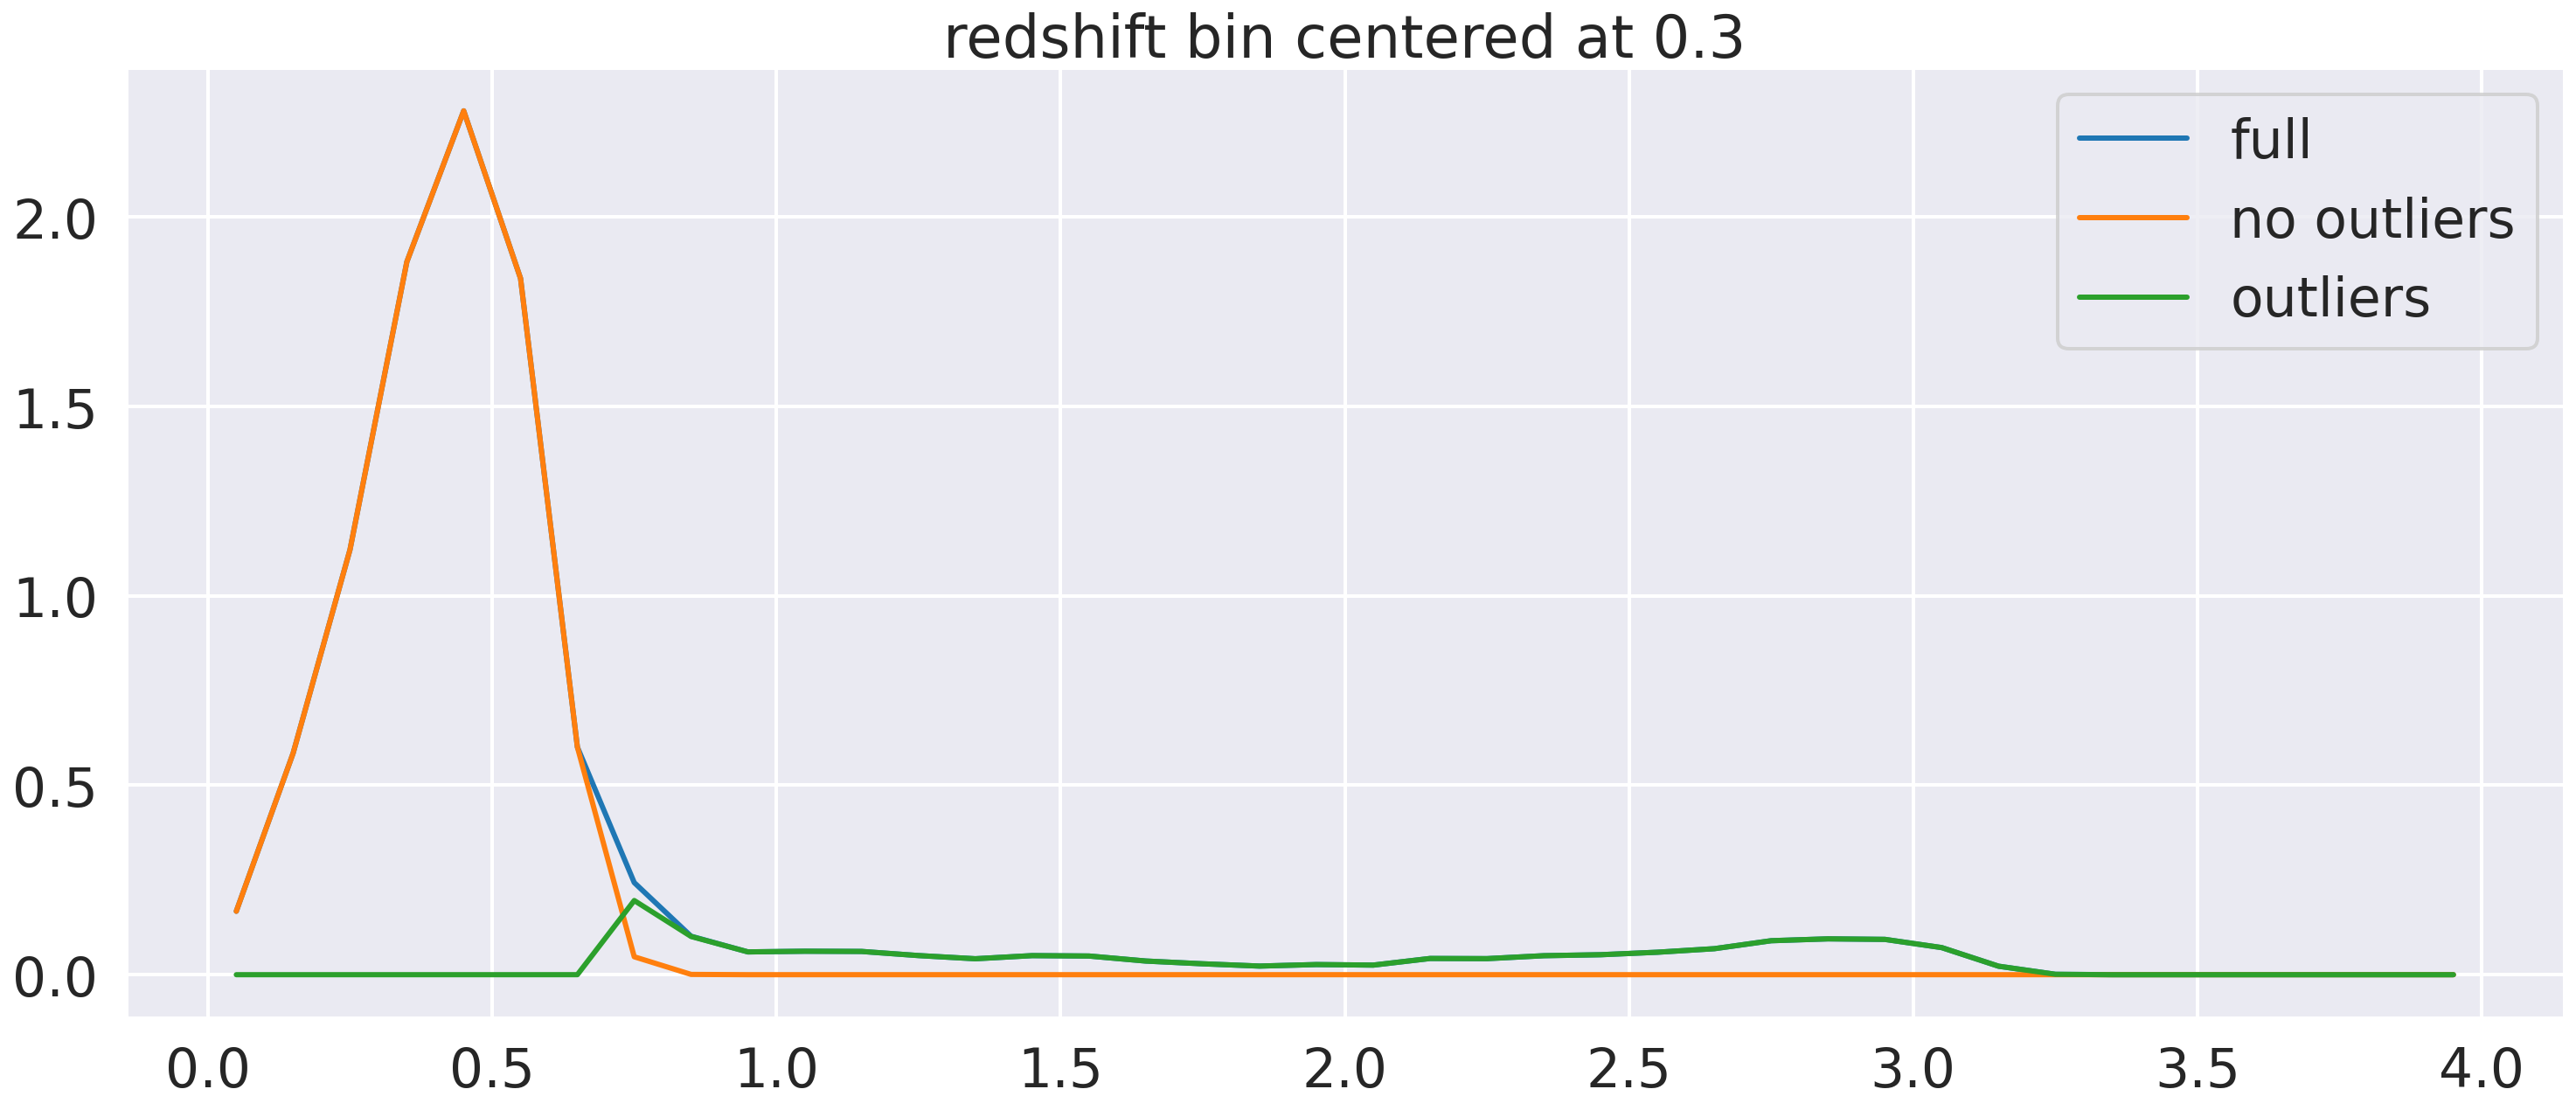

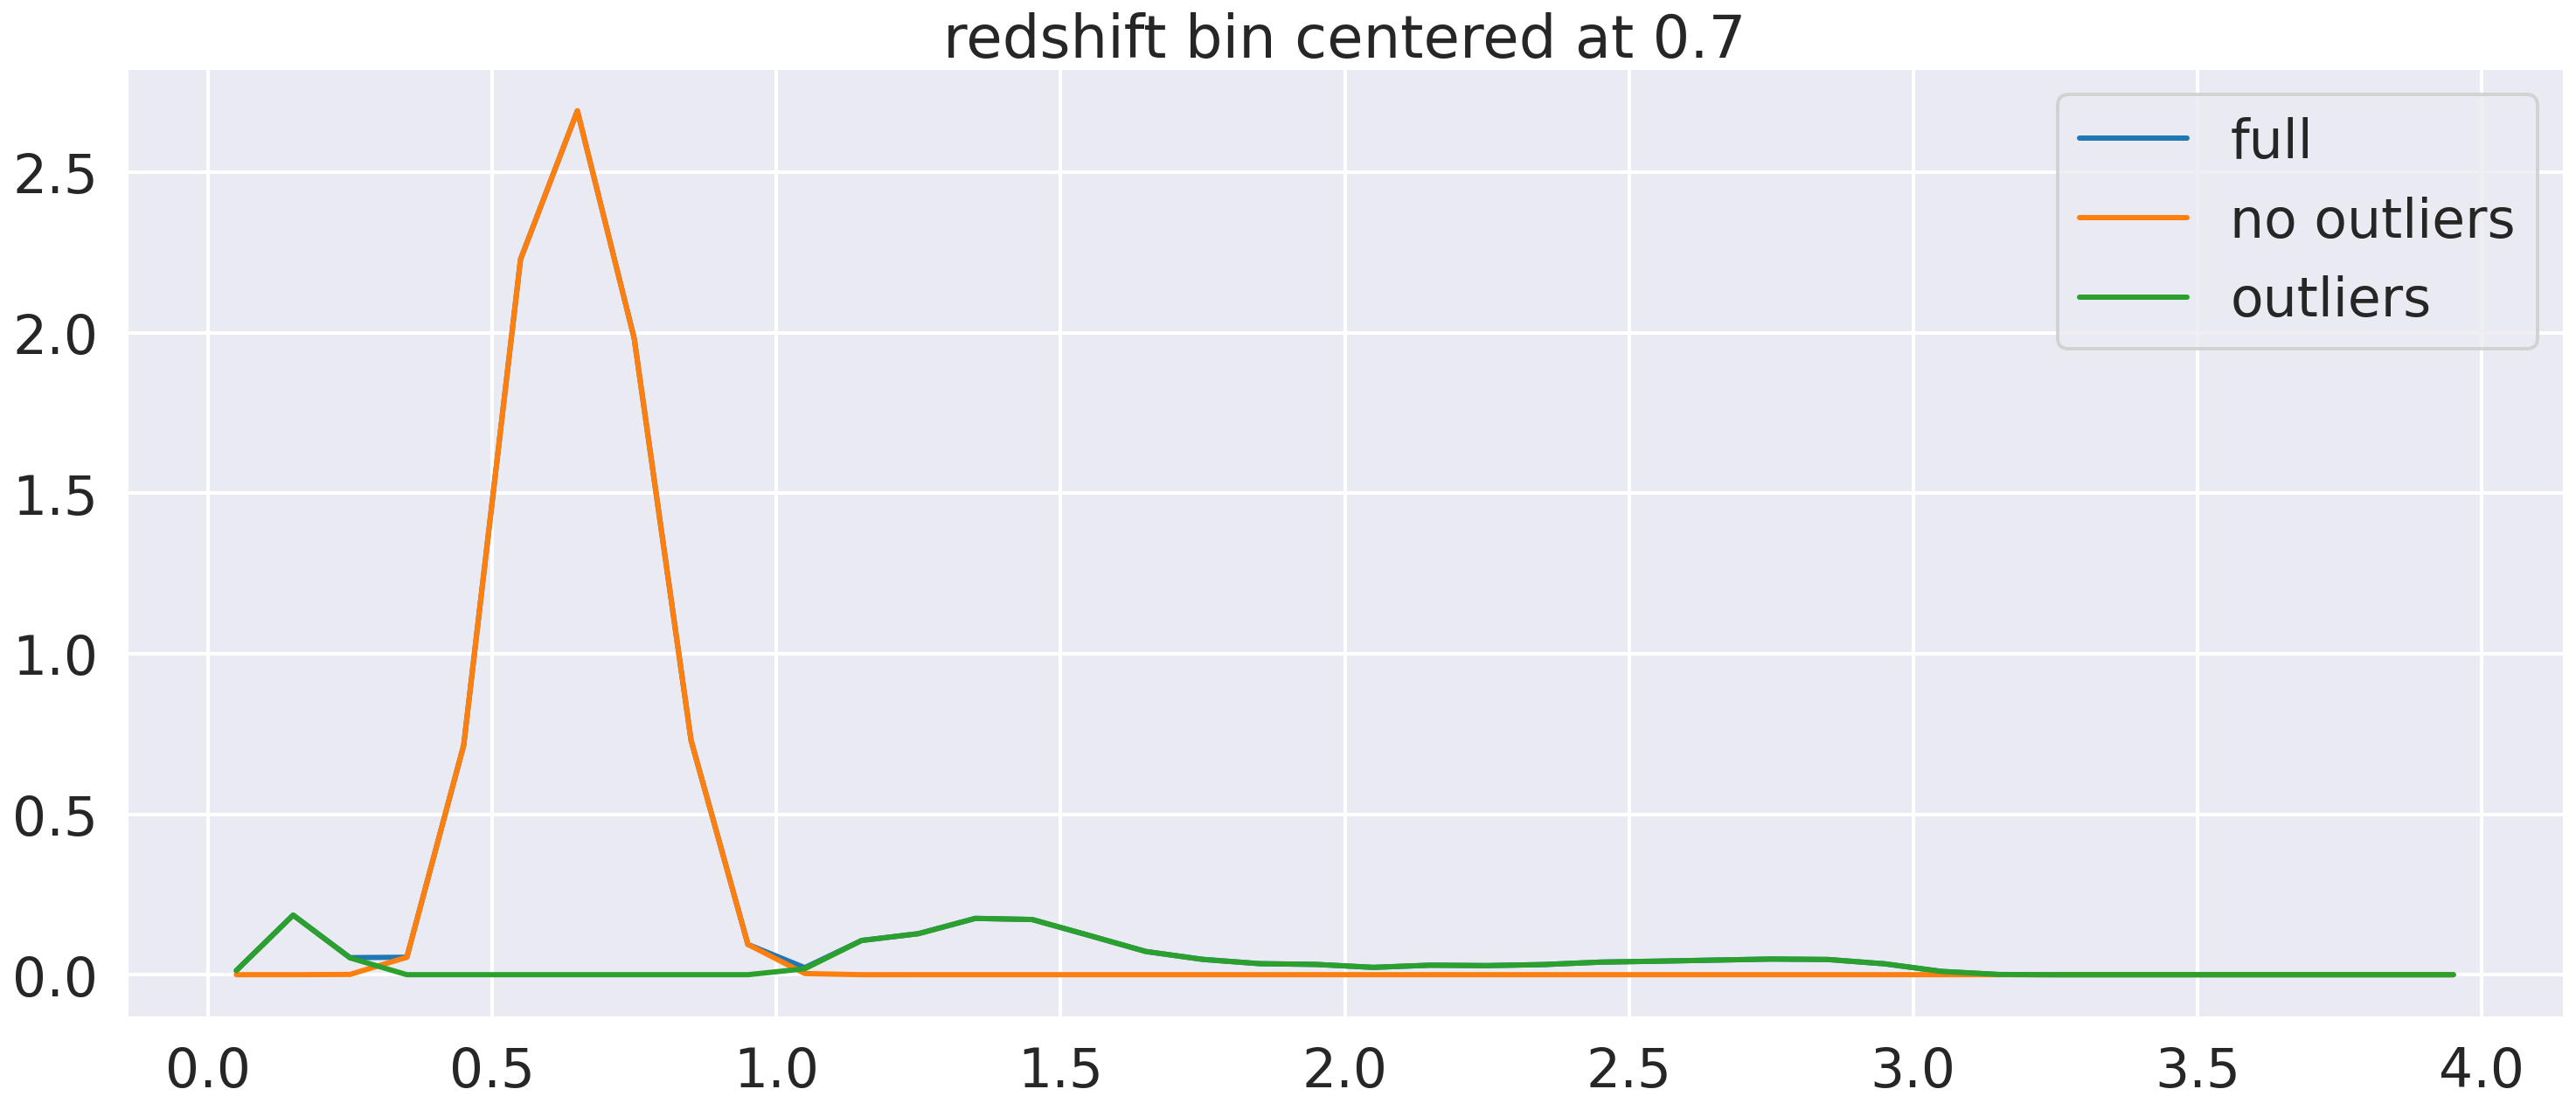

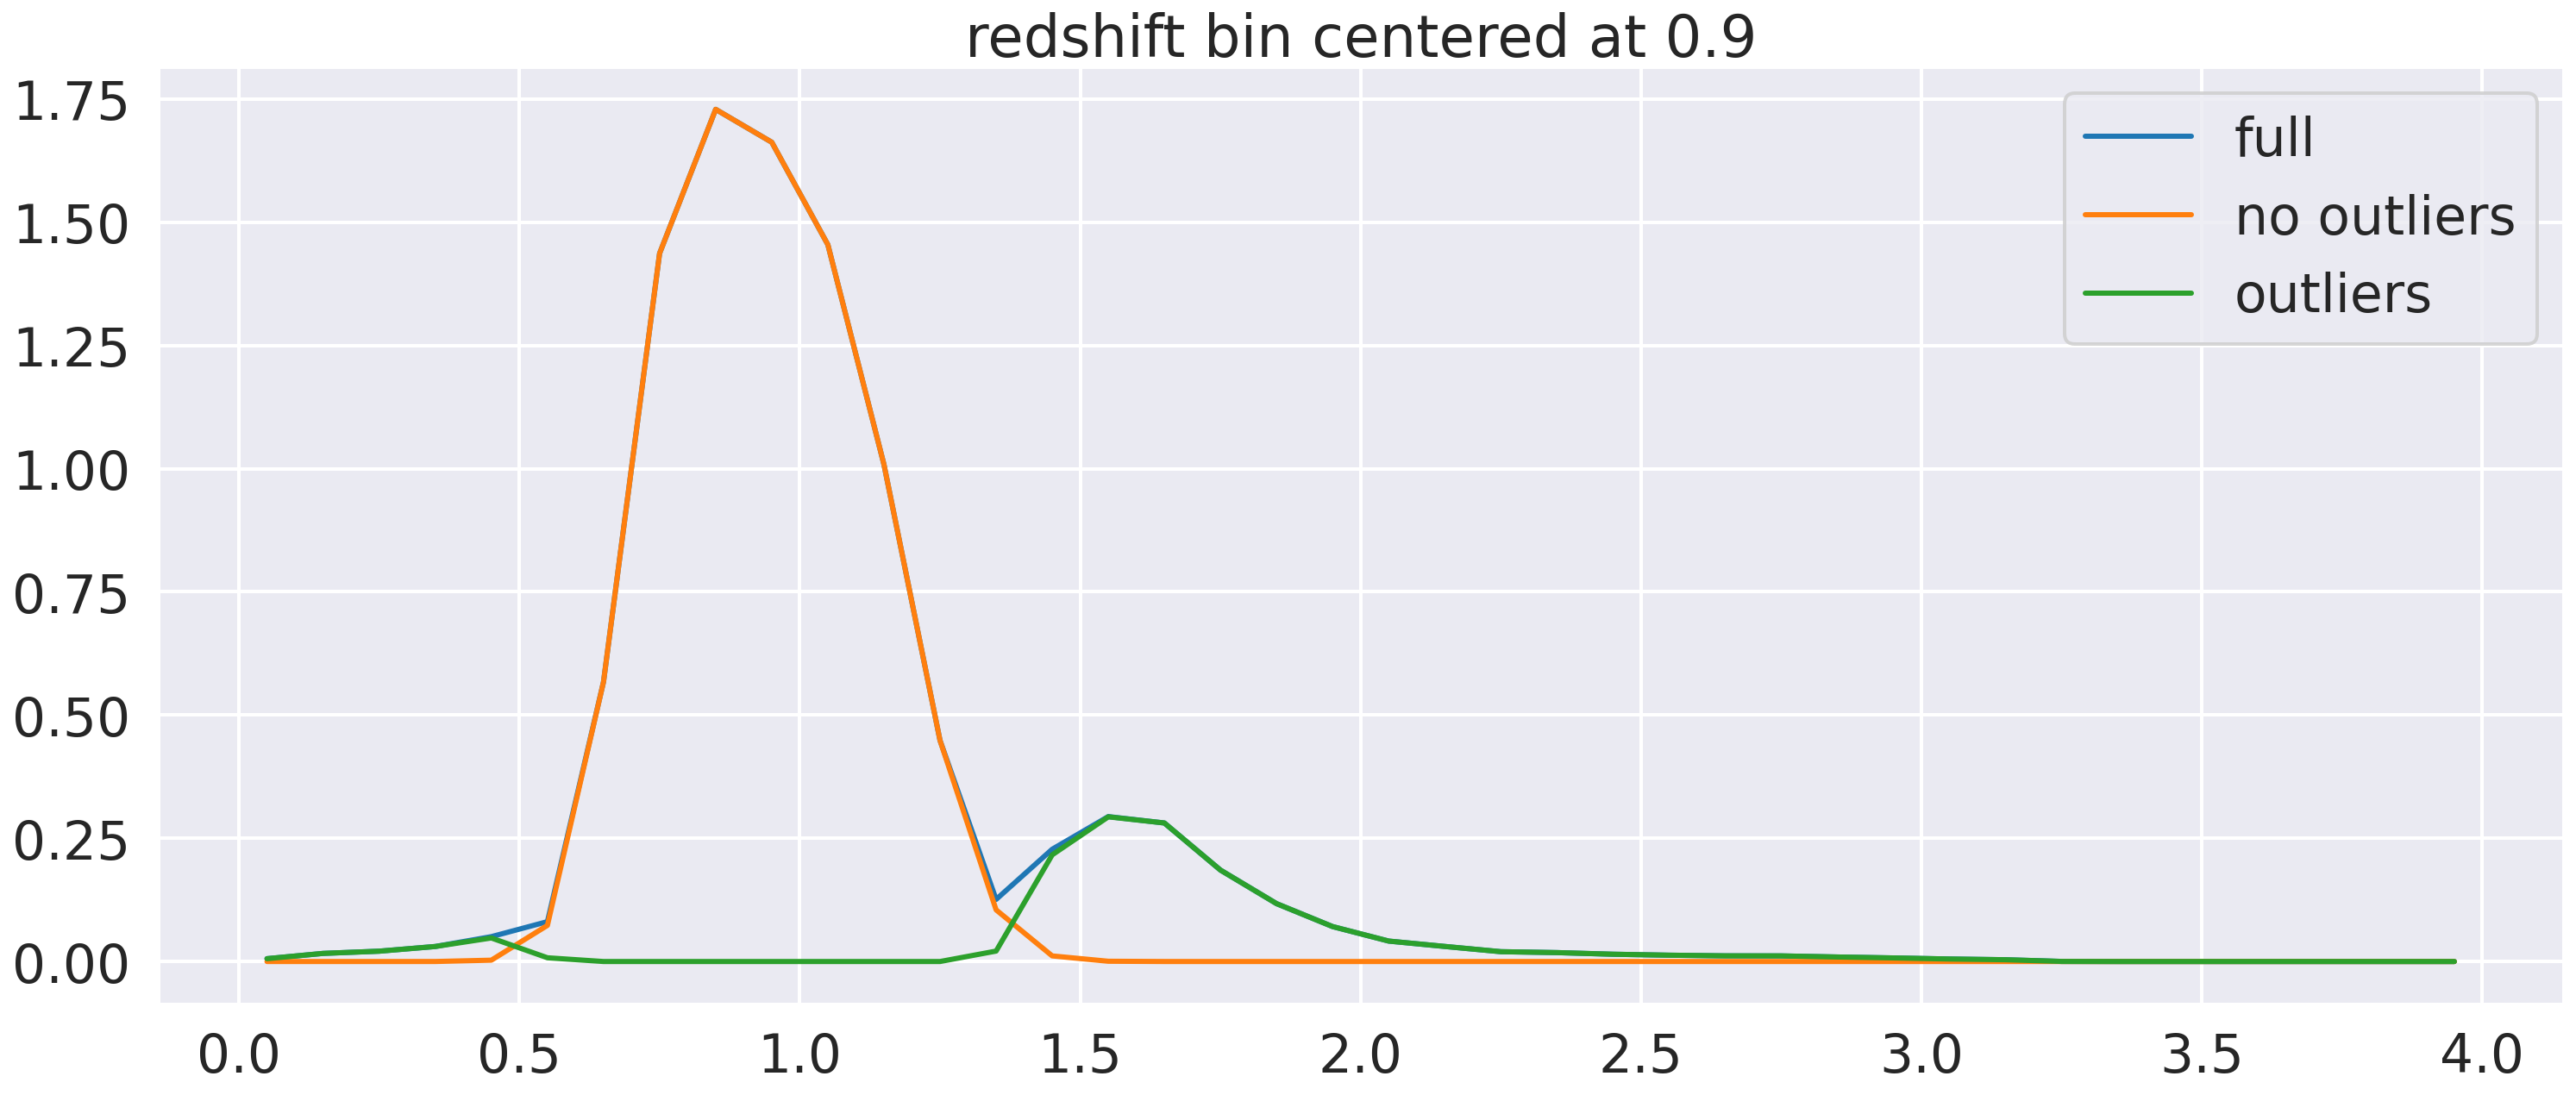

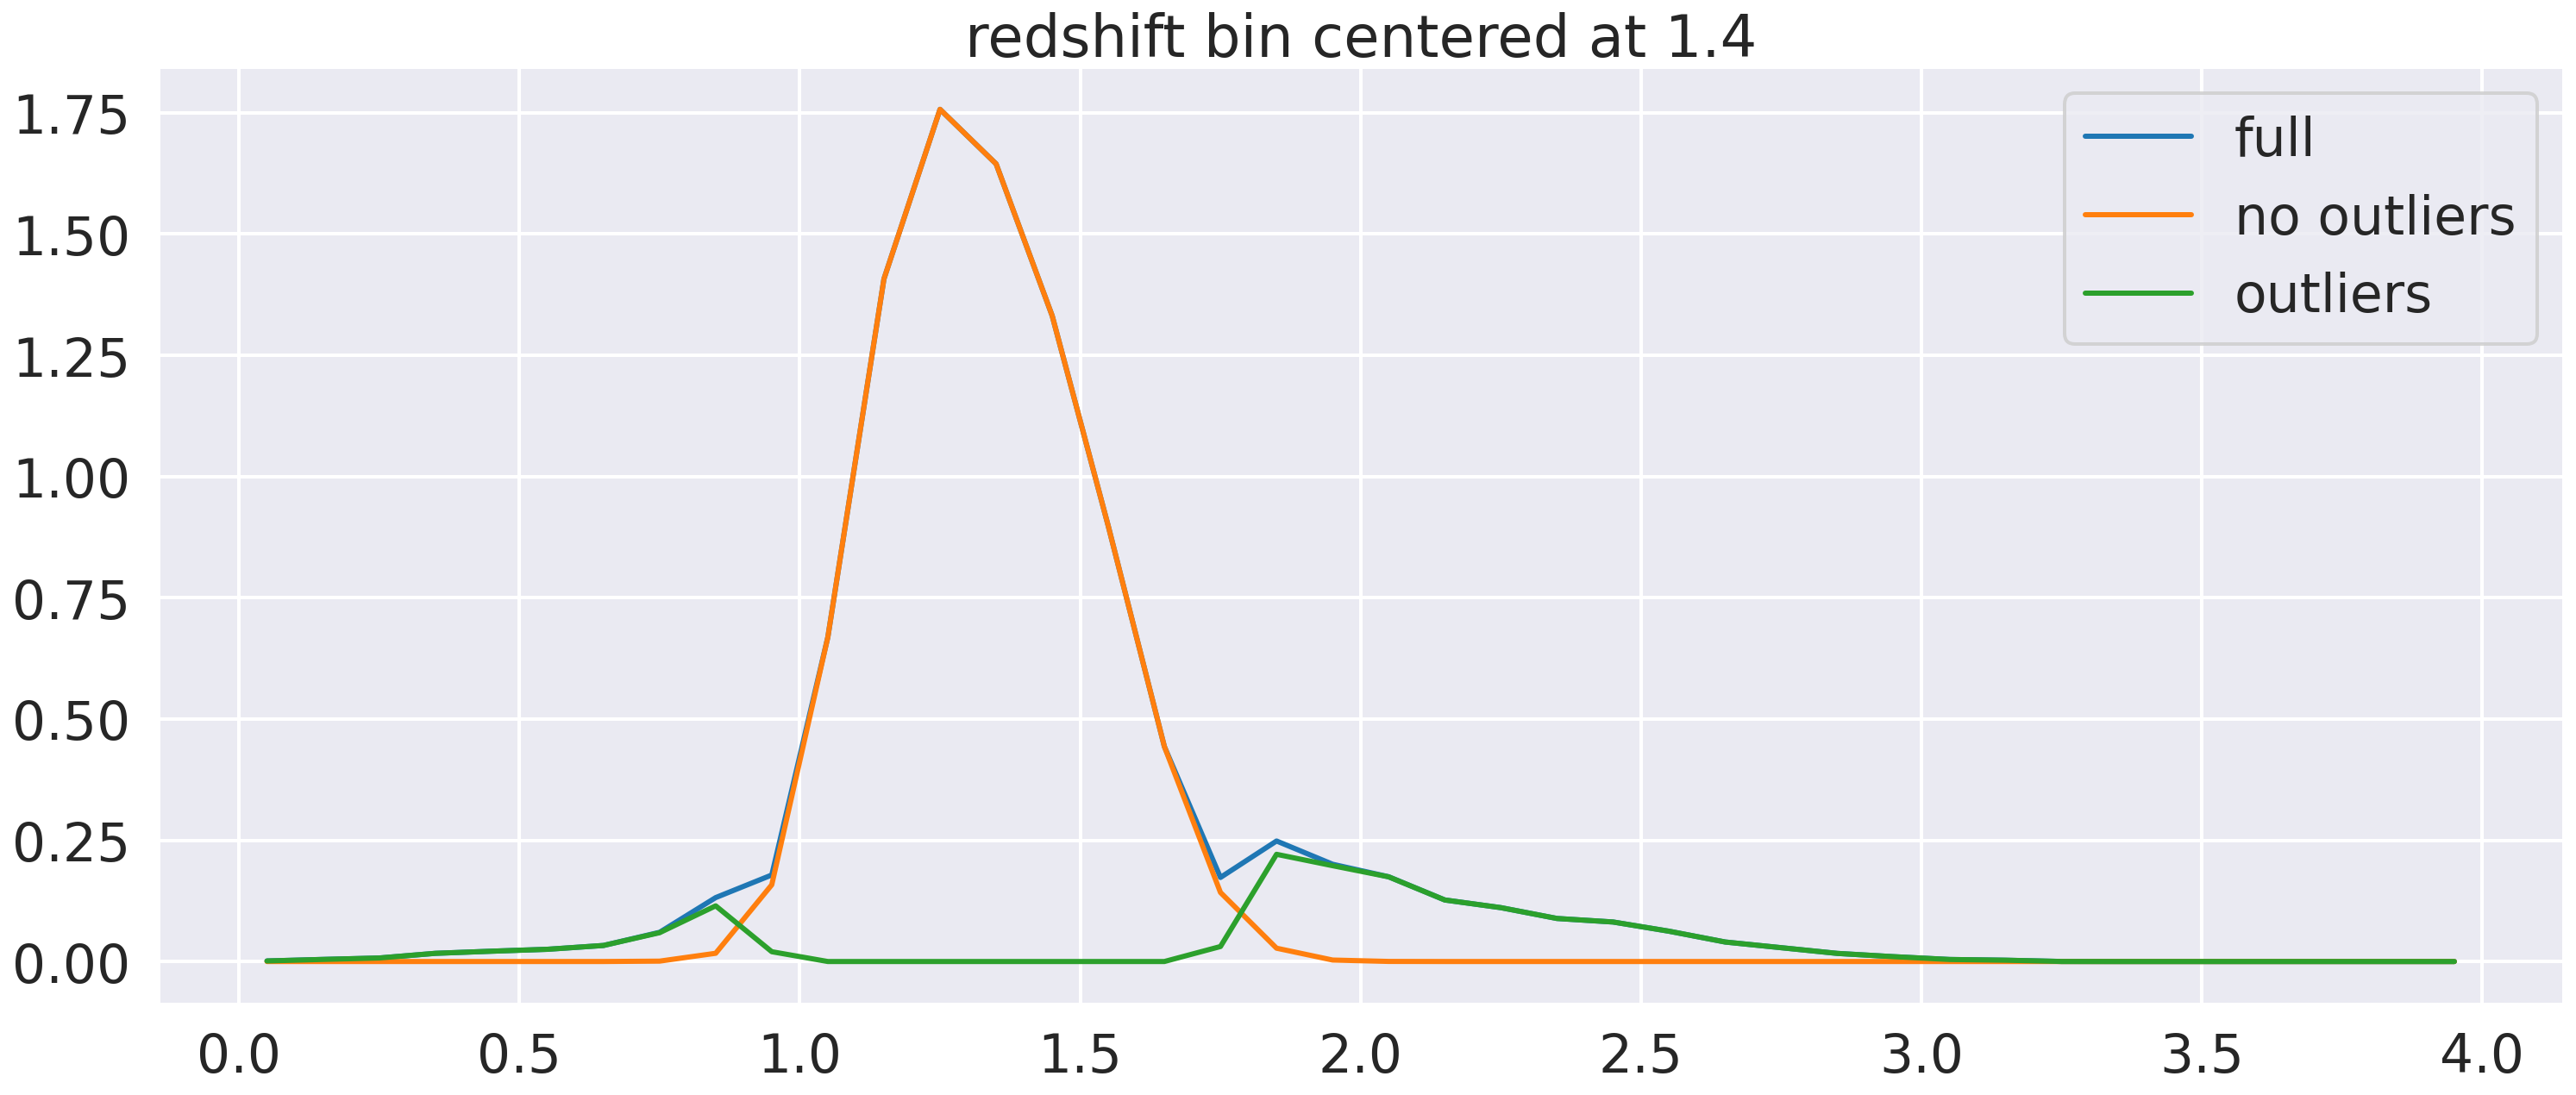

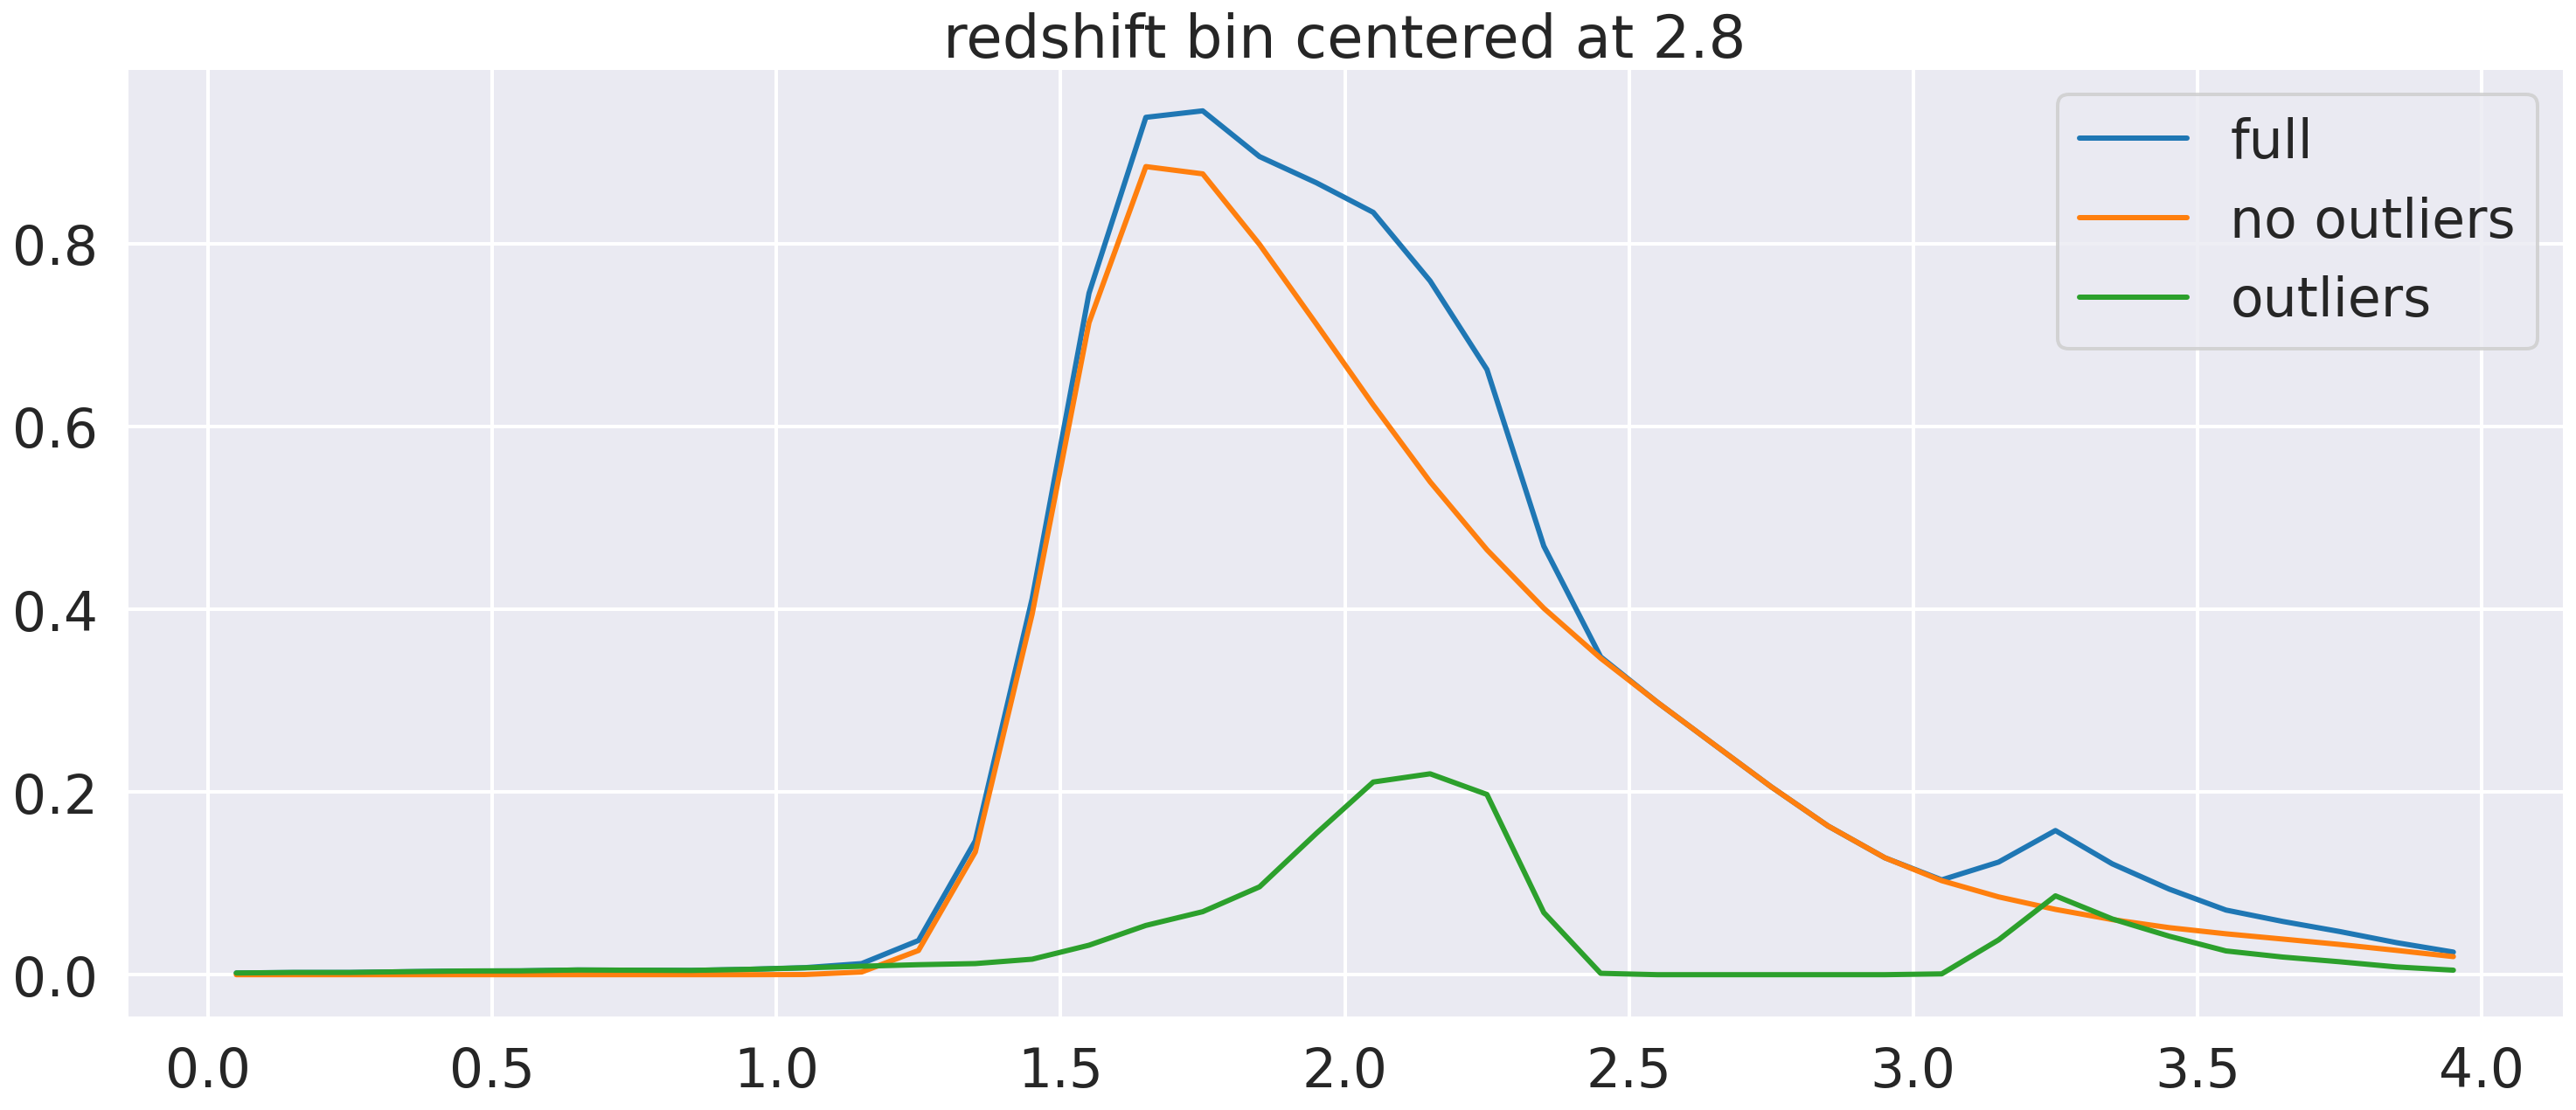

In [117]:
for i, key in enumerate(obj.dNdz_dict_source.keys()):
    kde = obj.KDEs[i]
    plt.figure()
    _ = sns.lineplot(x=obj.zmid, y=obj.dNdz_dict_source[key], markers=False, label='full')
    _ = sns.lineplot(x=obj.zmid, y=0.85*no_outliers[key], markers=False, label='no outliers')
    _ = sns.lineplot(x=obj.zmid, y=obj.scores[i]*0.15, markers=False, label='outliers')
    plt.title(f'redshift bin centered at {key:.1f}')
plt.legend()

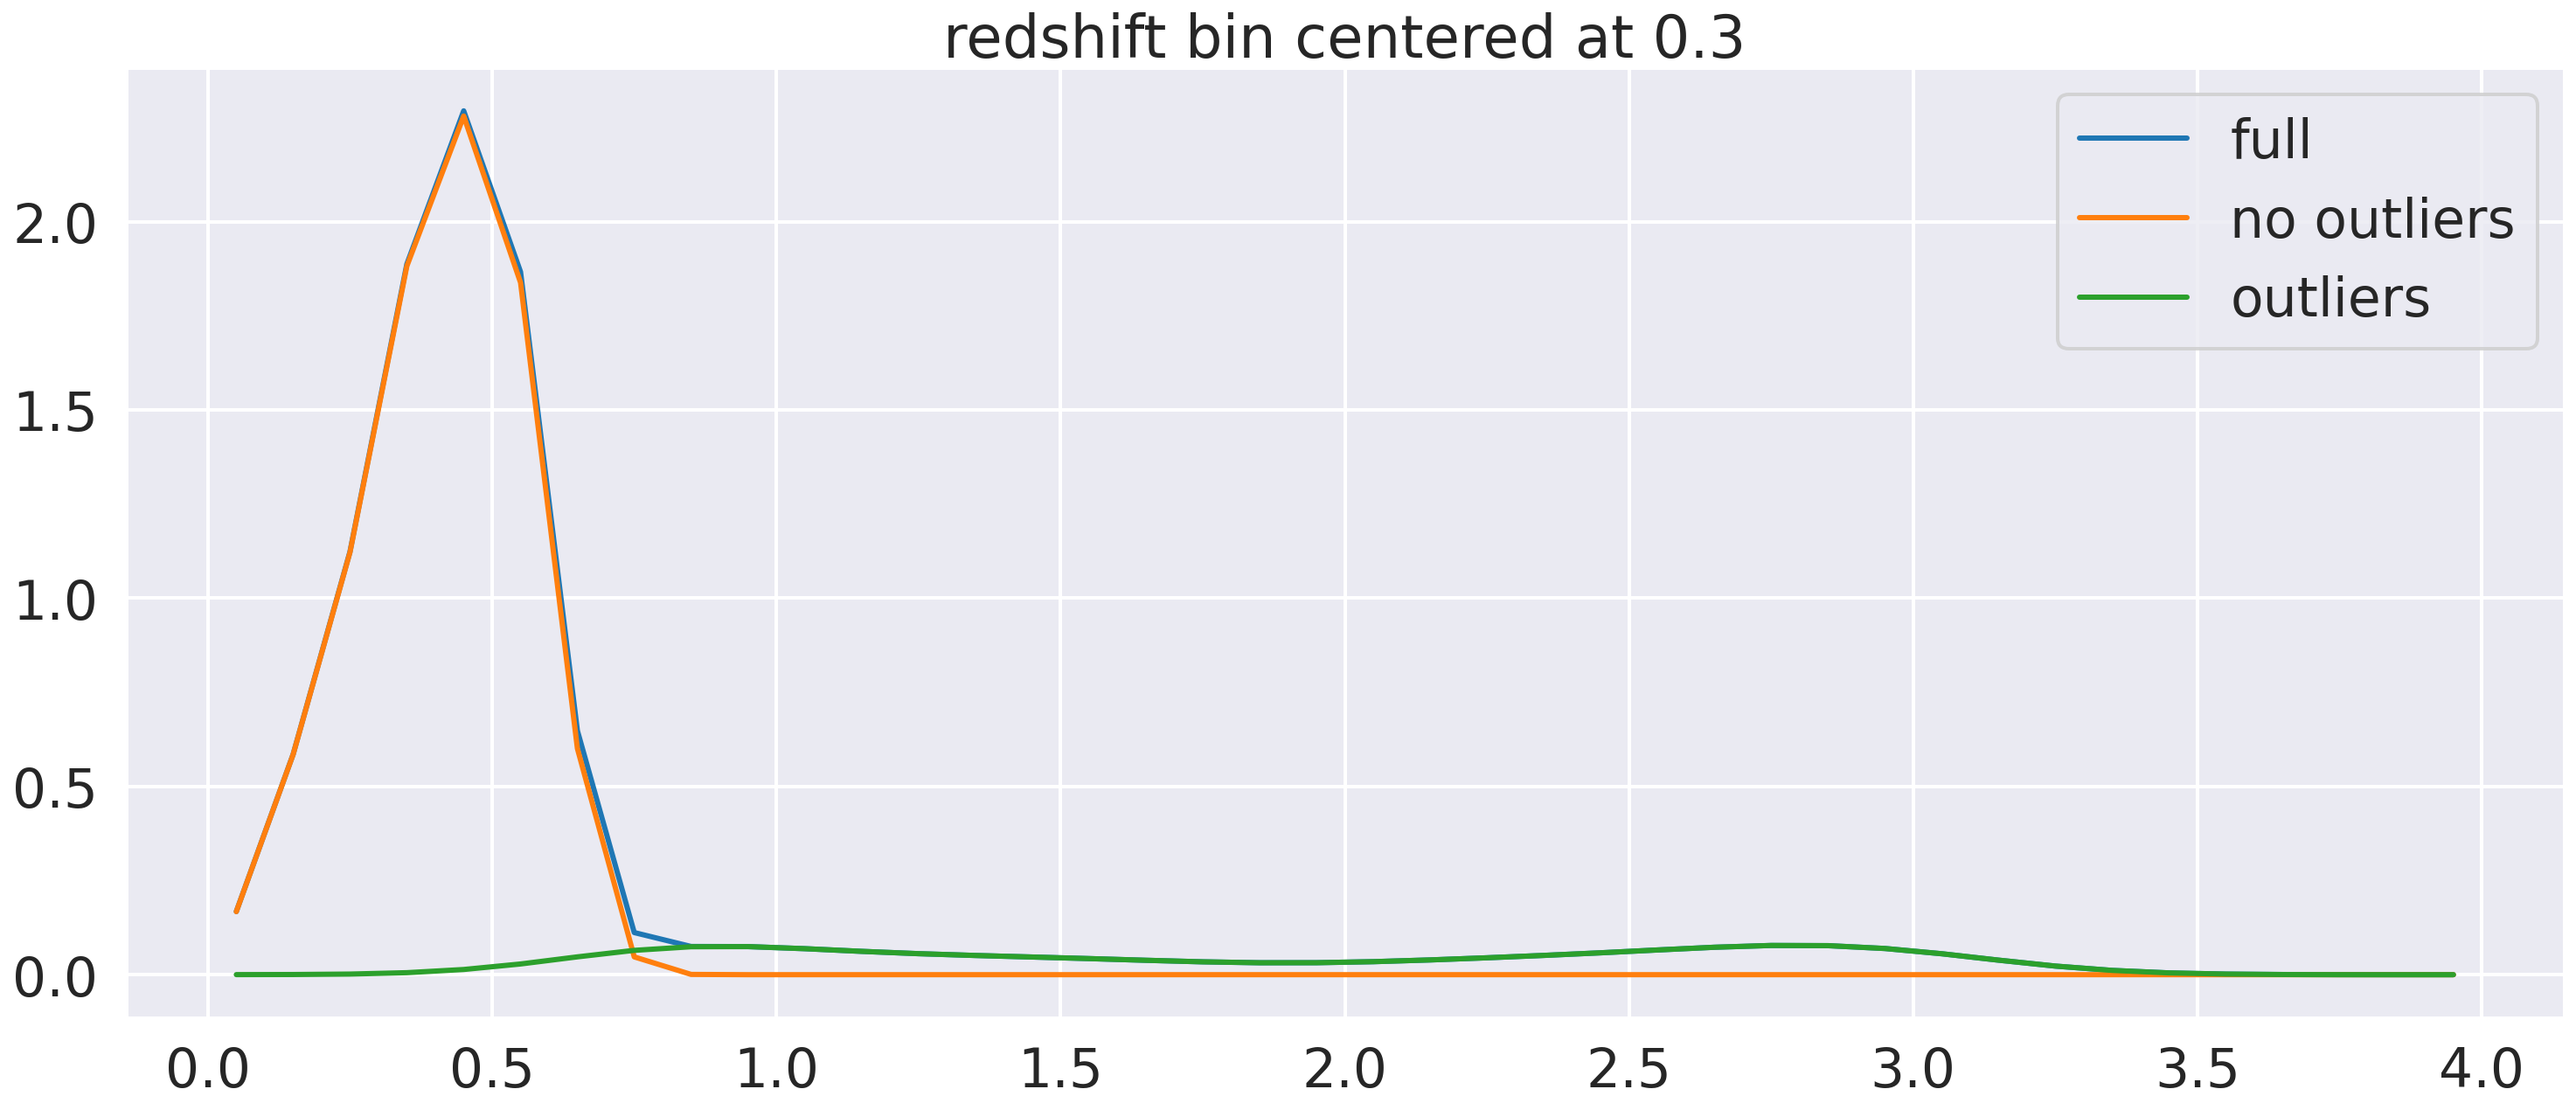

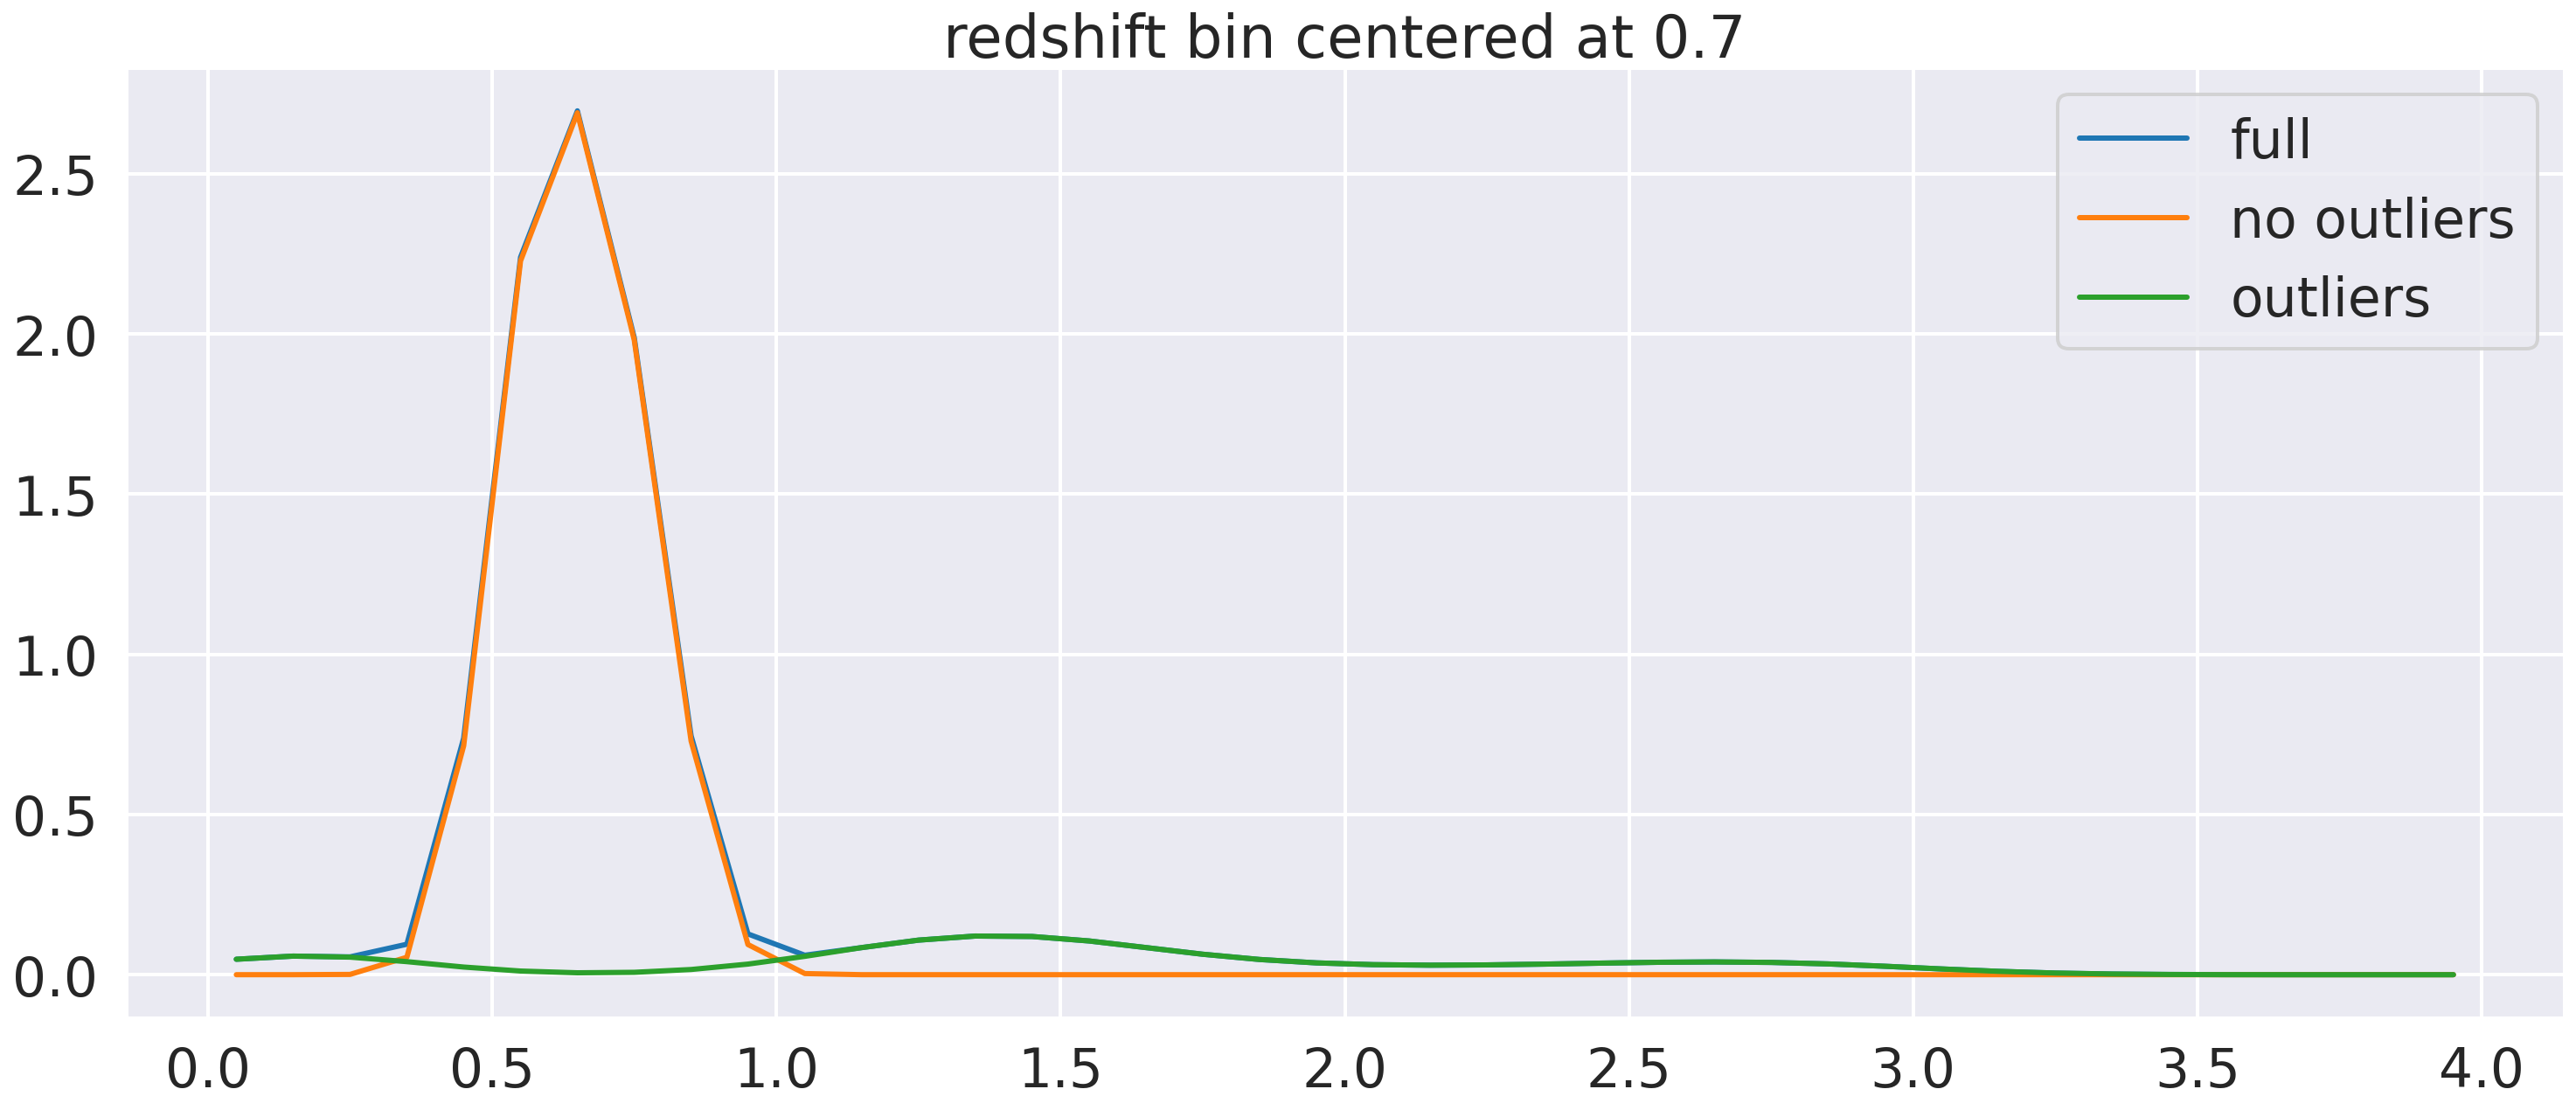

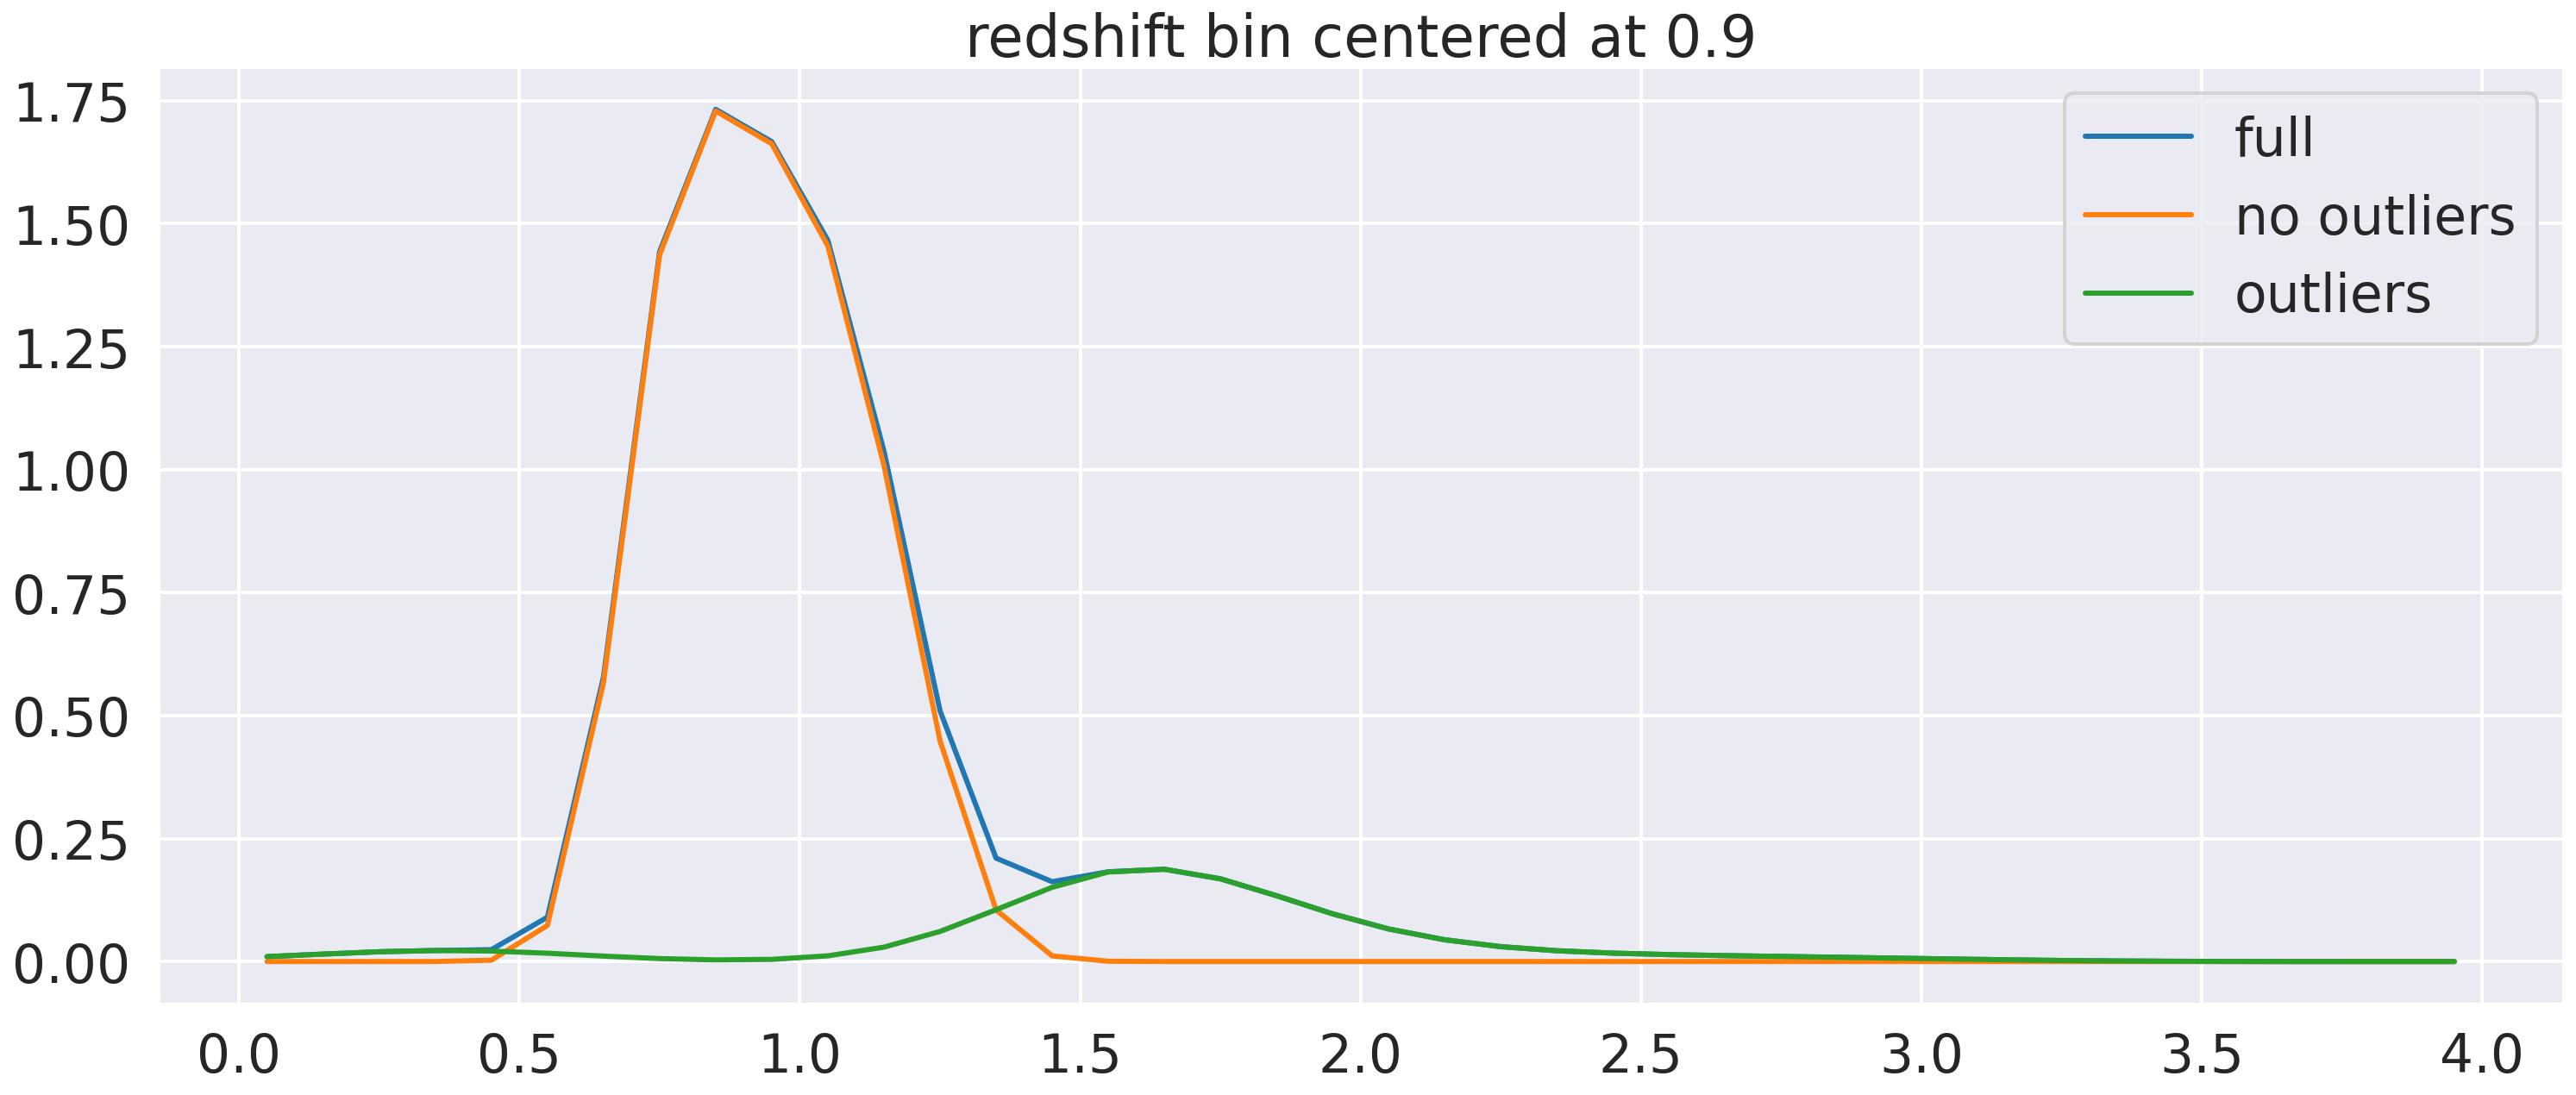

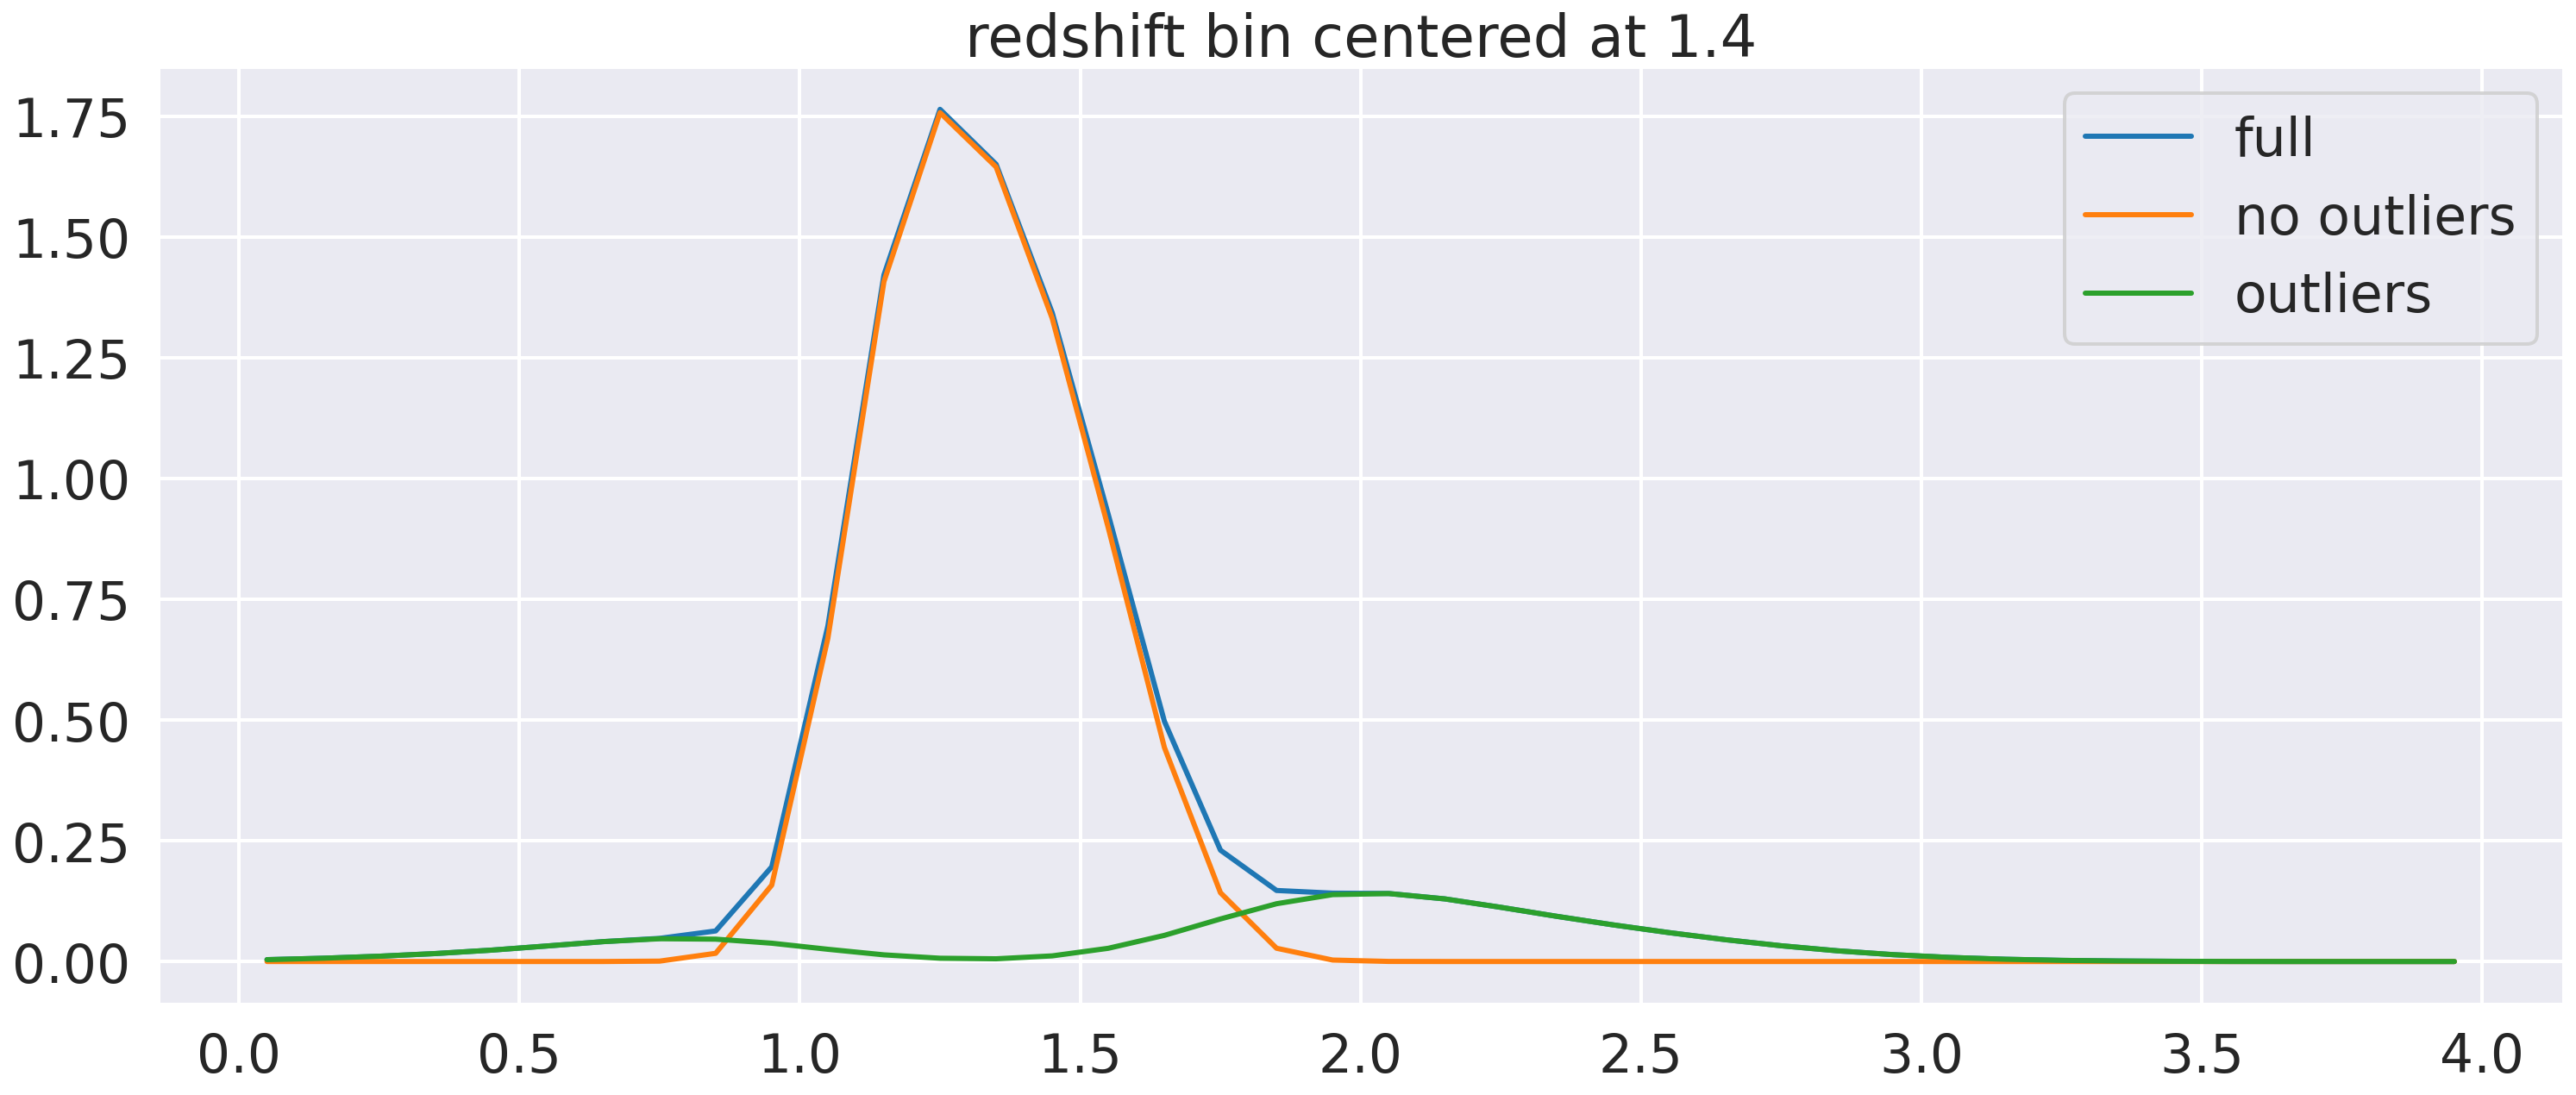

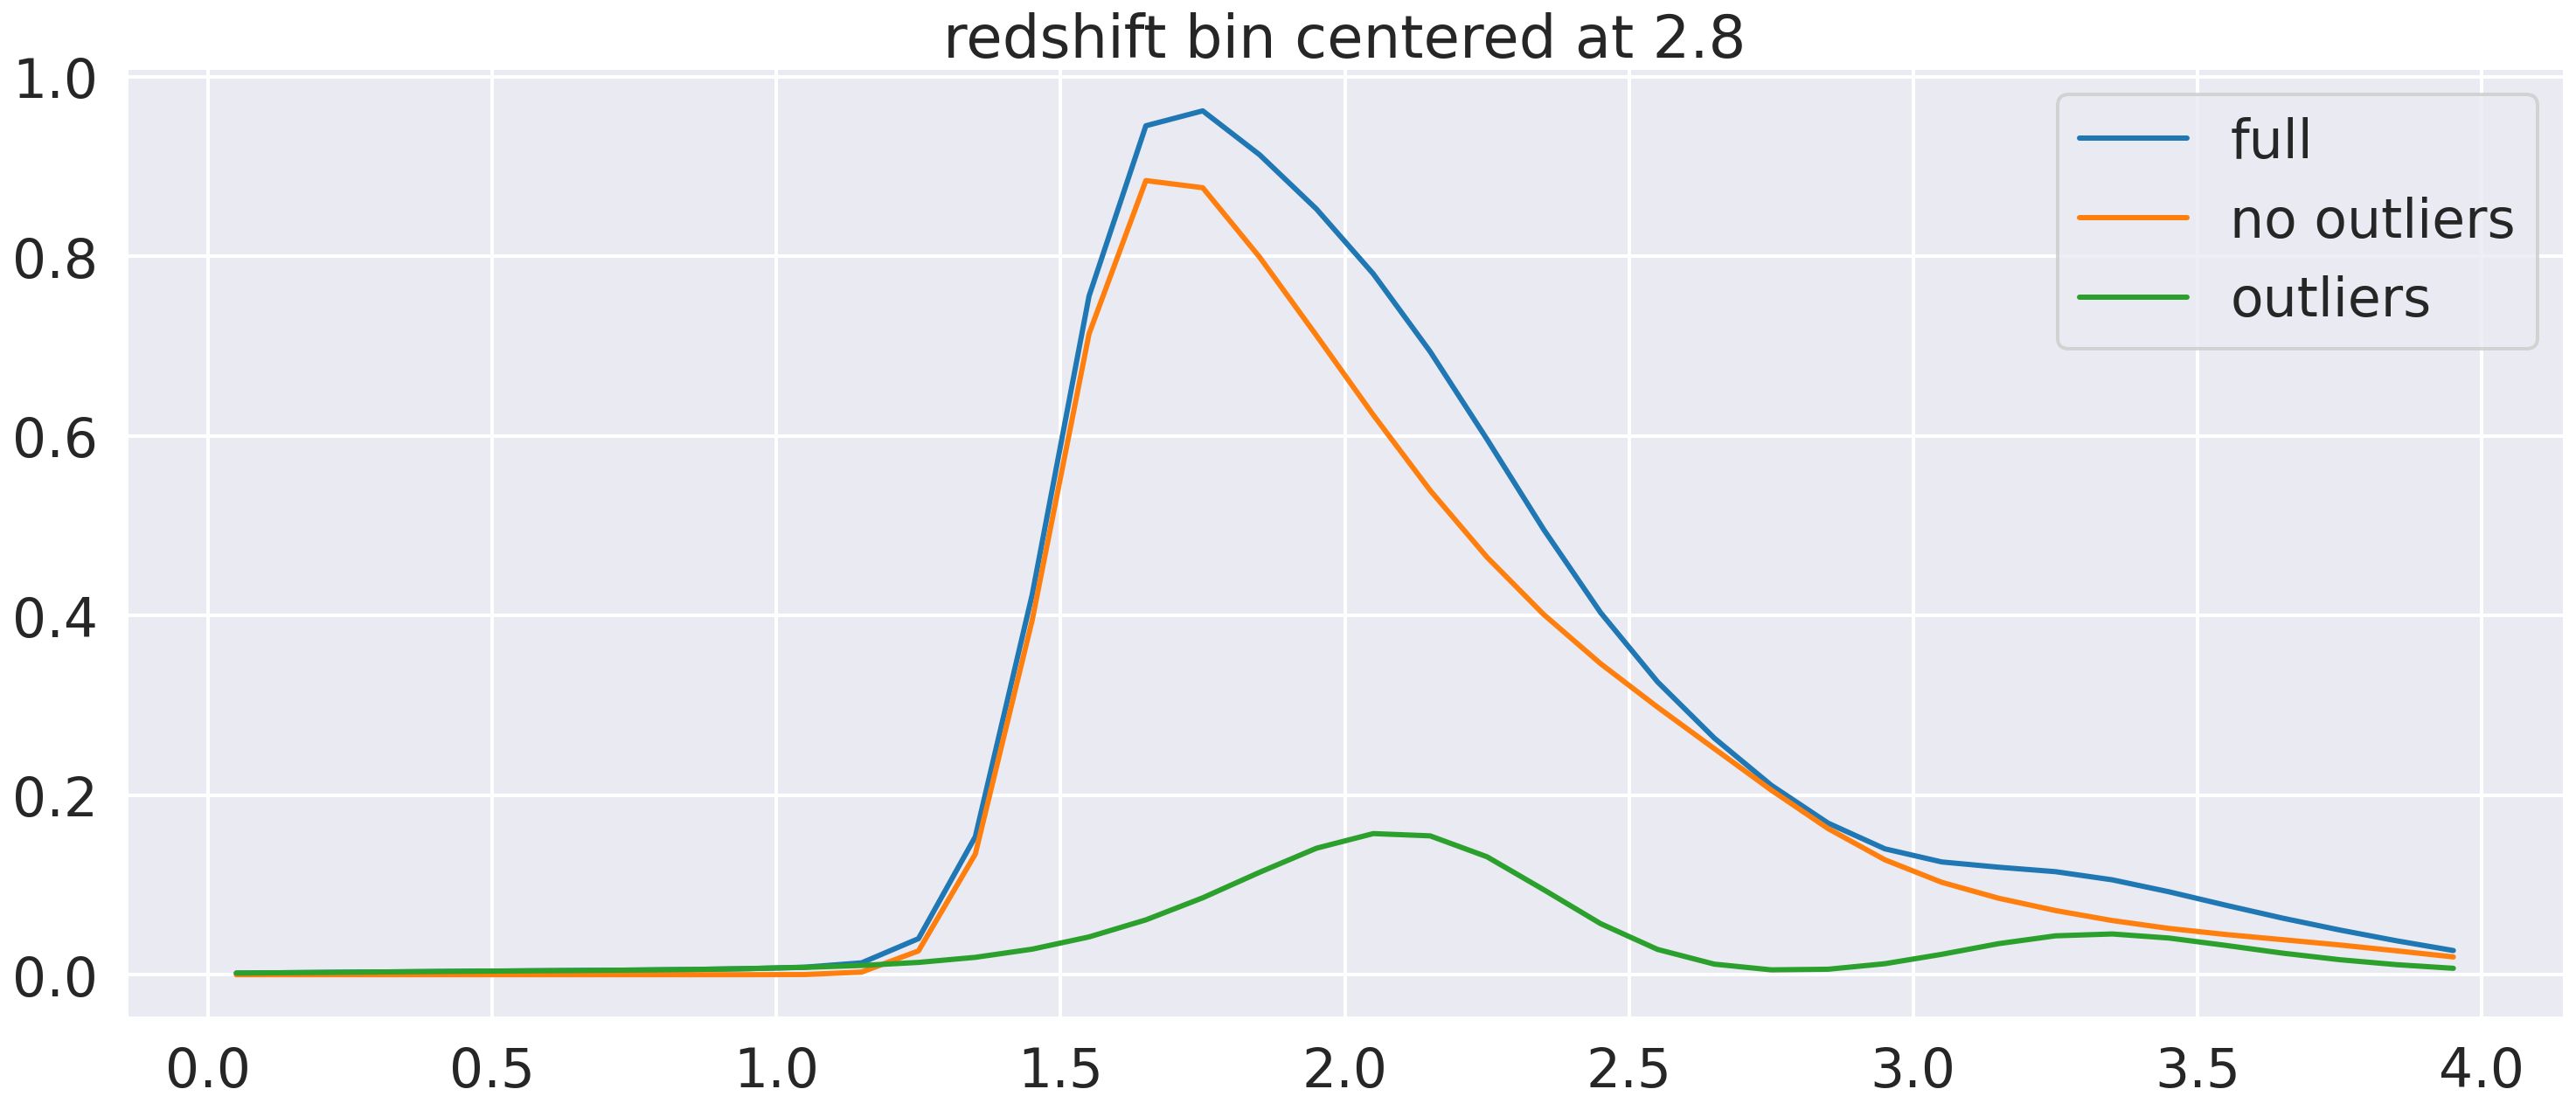

In [108]:
for i, key in enumerate(obj.dNdz_dict_source.keys()):
    kde = obj.KDEs[i]
    plt.figure()
    _ = sns.lineplot(x=obj.zmid, y=obj.dNdz_dict_source[key], markers=False, label='full')
    _ = sns.lineplot(x=obj.zmid, y=0.85*no_outliers[key], markers=False, label='no outliers')
    _ = sns.lineplot(x=obj.zmid, y=obj.scores[i]*0.15, markers=False, label='outliers')
    plt.title(f'redshift bin centered at {key:.1f}')
plt.legend()

In [6]:
from itertools import chain

In [23]:
from fisher import SmailZ, Core, PhotozModel
from scipy.stats import uniform
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

In [33]:
obj._NormalizePZ??

Signature: obj._NormalizePZ(qs, dNdz_dict_source, m=1)
Docstring: <no docstring>
Source:   
    def _NormalizePZ(self, qs, dNdz_dict_source, m=1):
        for q, k in zip(qs, dNdz_dict_source.keys()):
            dNdz_dict_source[k] = dNdz_dict_source[k]*sum(qs)/q
            f = CubicSpline(self.zmid, dNdz_dict_source[k])
            d = quad(f, 0, 4)[0]
            for k in dNdz_dict_source.keys():
                dNdz_dict_source[k] /= (d*m)
            return dNdz_dict_source
File:      /global/u2/h/husni/PZ_Project/fisher.py
Type:      method


In [112]:
KDEs

{0: KernelDensity(bandwidth=0.02),
 1: KernelDensity(bandwidth=0.02),
 2: KernelDensity(bandwidth=0.02),
 3: KernelDensity(bandwidth=0.02),
 4: KernelDensity(bandwidth=0.02)}

In [115]:
KDEs = pickle.load(open('KDEs.p', 'rb'))

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KernelDensity from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [ ]:
n = len(obj.zmid)
datapts = ([list(np.ones(int(obj.dneff[i]/min(obj.dneff)))*obj.zmid[i]) for i in range(n)])
datapts = list(chain.from_iterable(datapts)) # flatten
bins = datapts[0::int(len(datapts)/5)]
bin_centers = [.5*sum([bins[i]+bins[i+1]]) for i in range(len(bins[:-1]))]
pdf_z = SmailZ(obj.zmid, np.array(obj.dneff))
dNdz_dict_source = {}
qs = []
for index, (x,x2) in enumerate(zip(bins[:-1], bins[1:])):
    bias = obj.zbias[index]
    variance = obj.zvariance[index]
    core = Core(obj.zmid, zbias=0.1*bias, sigma_z=variance*0.05)
    tomofilter = uniform.pdf(obj.zmid, loc=x, scale=x2-x)
    photoz_model = PhotozModel(pdf_z, core, [tomofilter])
    dNdz_dict_source[bin_centers[index]] = photoz_model.get_pdf()[0]

qs = []
if True:
    scores = {}
    KDEs = pickle.load(open('KDEs.p', 'rb'))
    for i, b in enumerate(list(sorted(dNdz_dict_source.keys()))):
        kde = KDEs[i]
        scores[i] = np.exp(kde.score_samples(np.array(obj.zmid).reshape(-1, 1)))
        f = CubicSpline(obj.zmid, dNdz_dict_source[b])
        q = quad(f, 0, 4)[0]
        fo = CubicSpline(obj.zmid, scores[i])
        qo = quad(fo, 0, 4)[0]
        dNdz_dict_source[b] /= q
        scores[i] /= qo
        dNdz_dict_source[b] = dNdz_dict_source[b]*0.85+scores[i]*0.15

In [71]:
for i, key in enumerate(dNdz_dict_source.keys()):
    f1 = CubicSpline(obj.zmid, dNdz_dict_source[key])
    print(quad(f1, 0, 4)[0])

0.9999999999254532
1.0000000000468088
1.0000000003491916
1.000000000173853
1.0000000164292395


In [110]:
KDEs

{0: KernelDensity(bandwidth=0.2),
 1: KernelDensity(bandwidth=0.2),
 2: KernelDensity(bandwidth=0.2),
 3: KernelDensity(bandwidth=0.2),
 4: KernelDensity(bandwidth=0.2)}

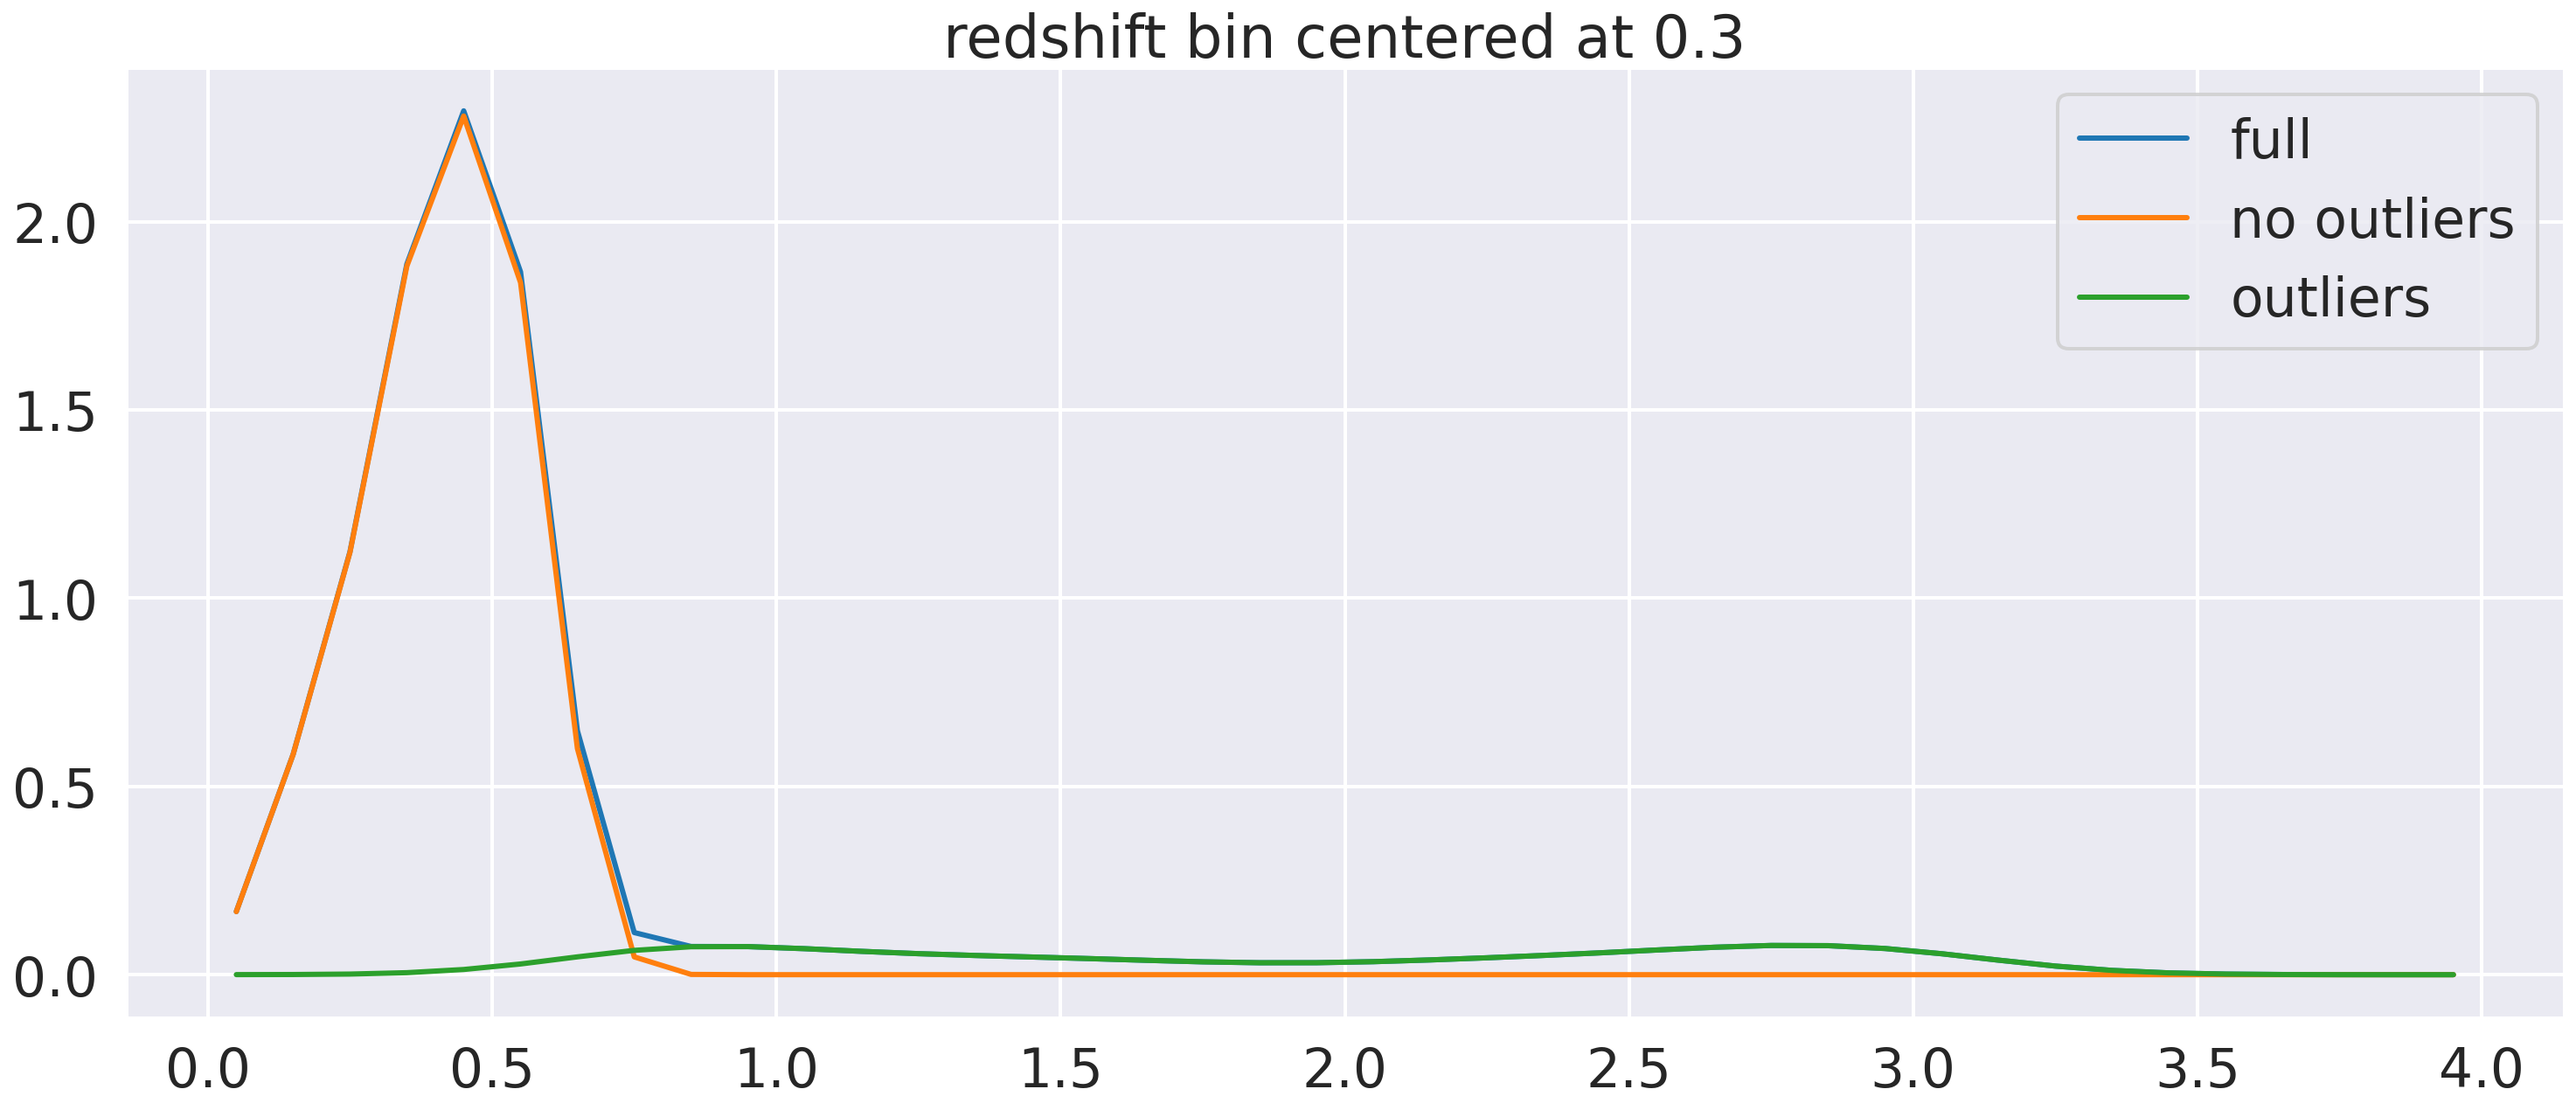

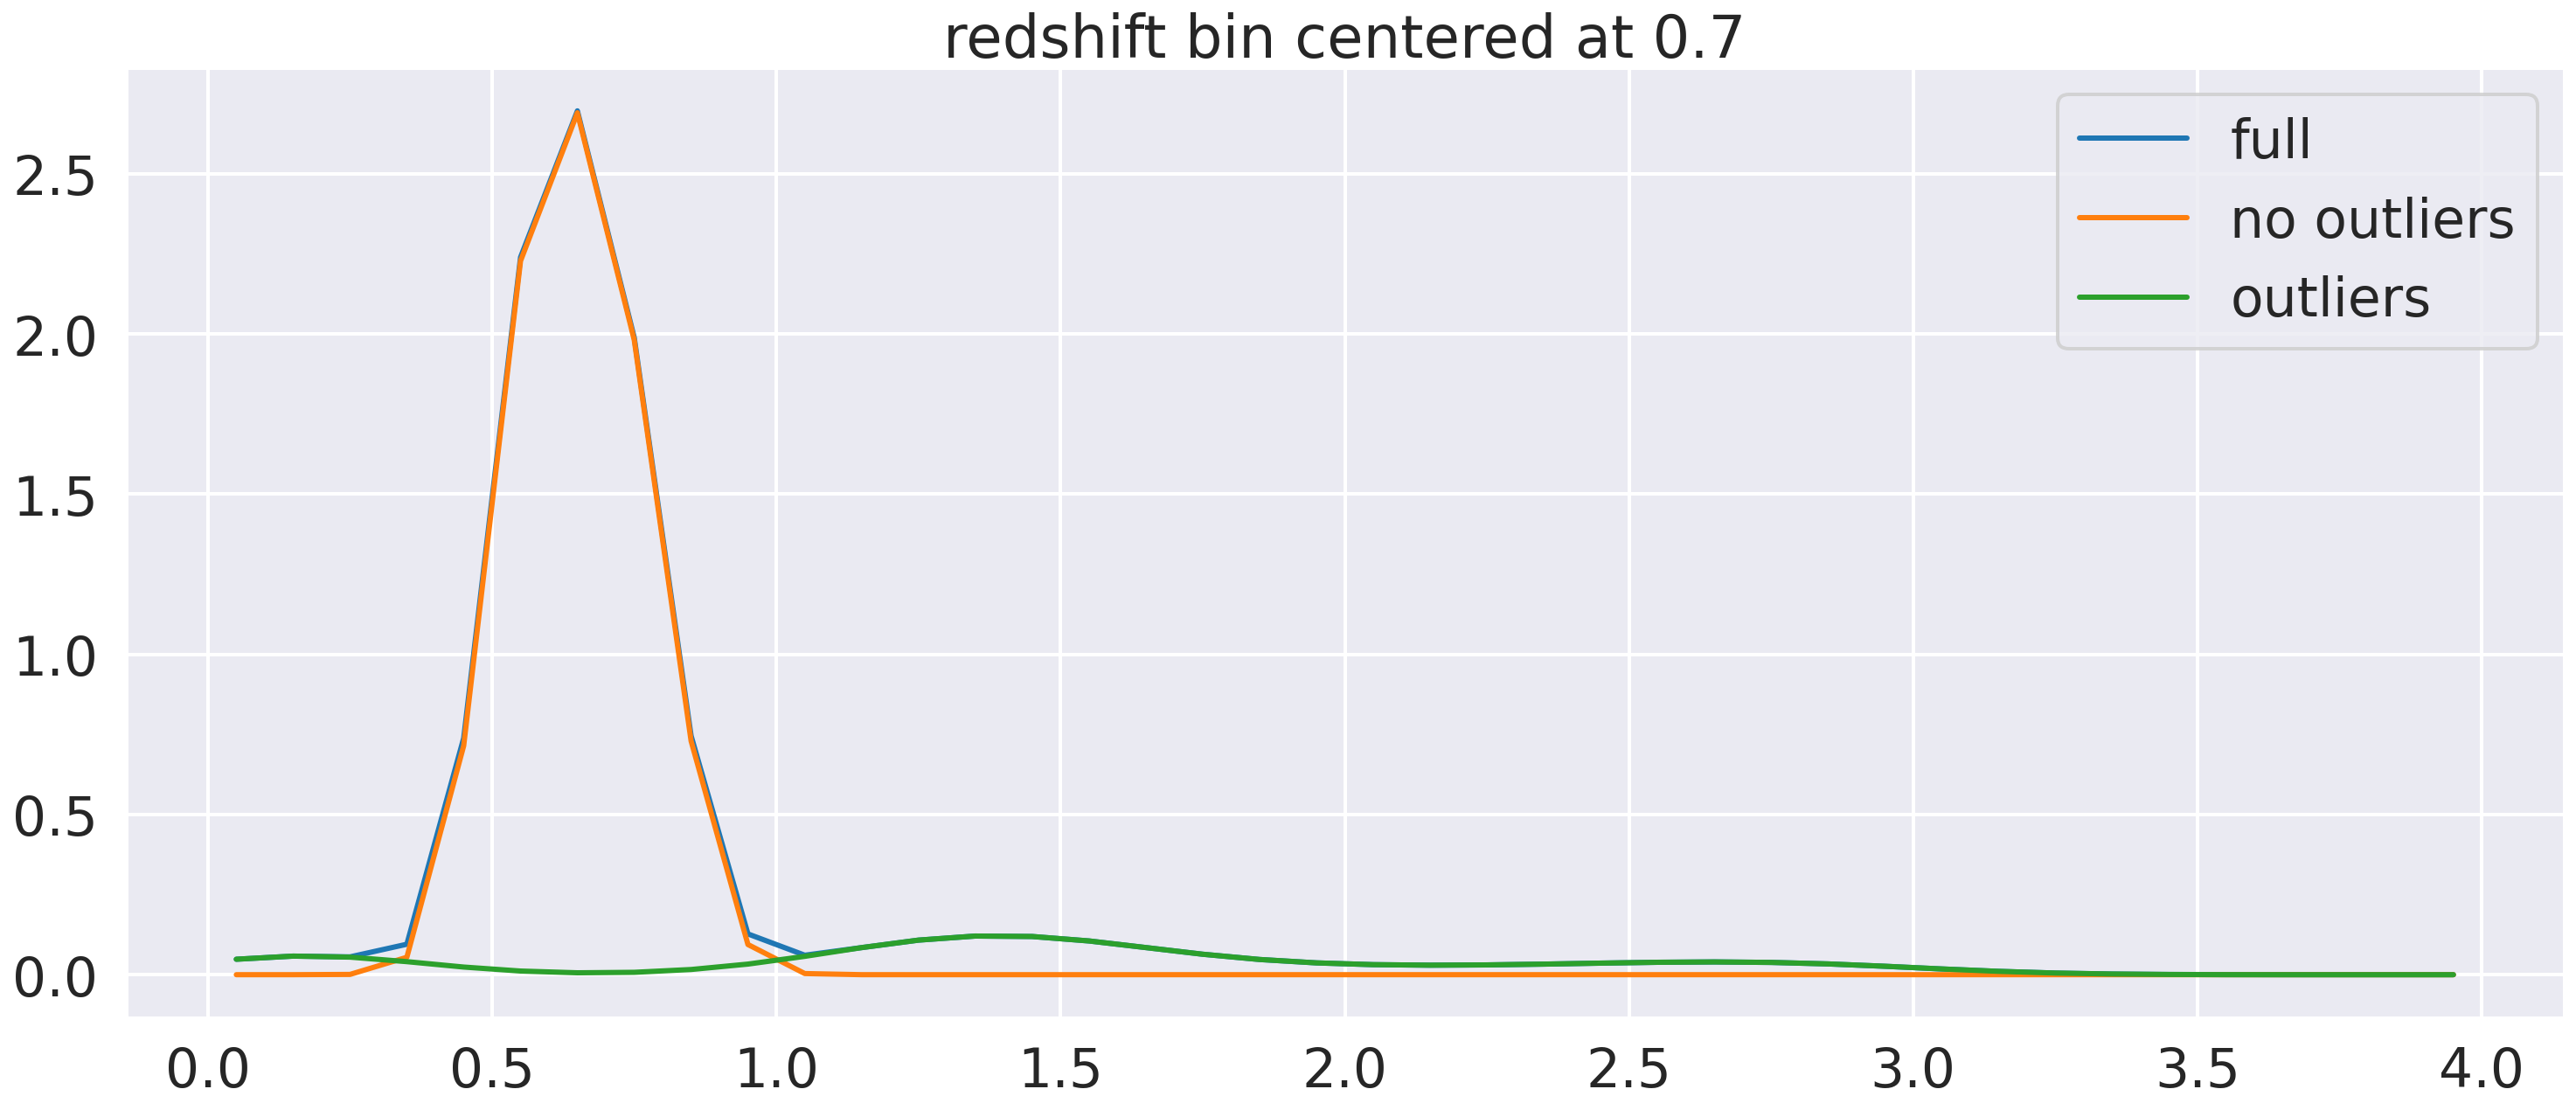

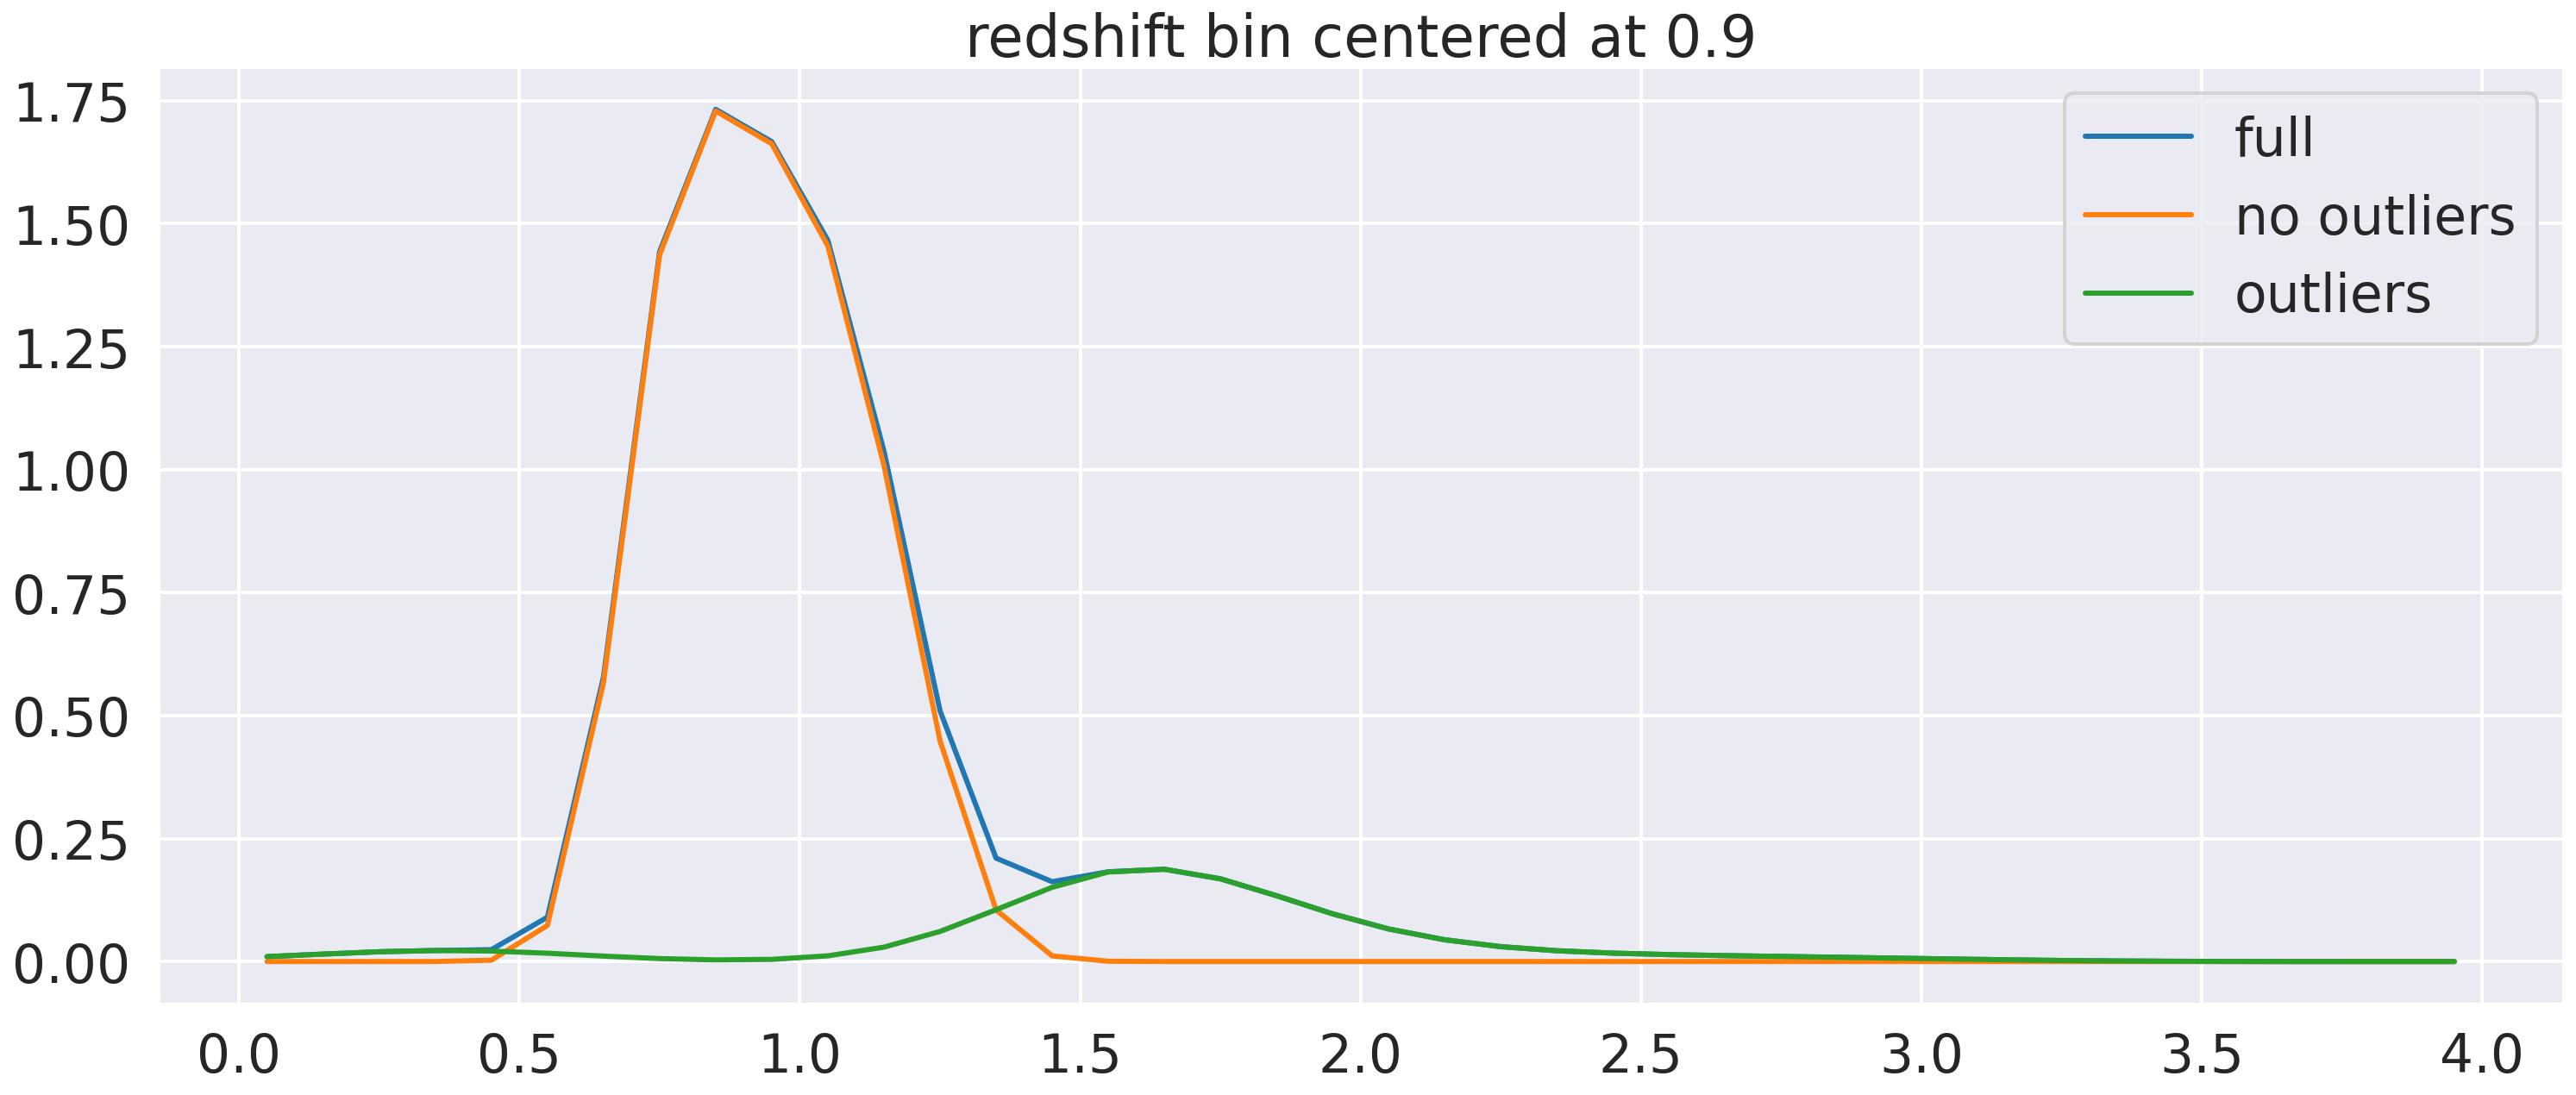

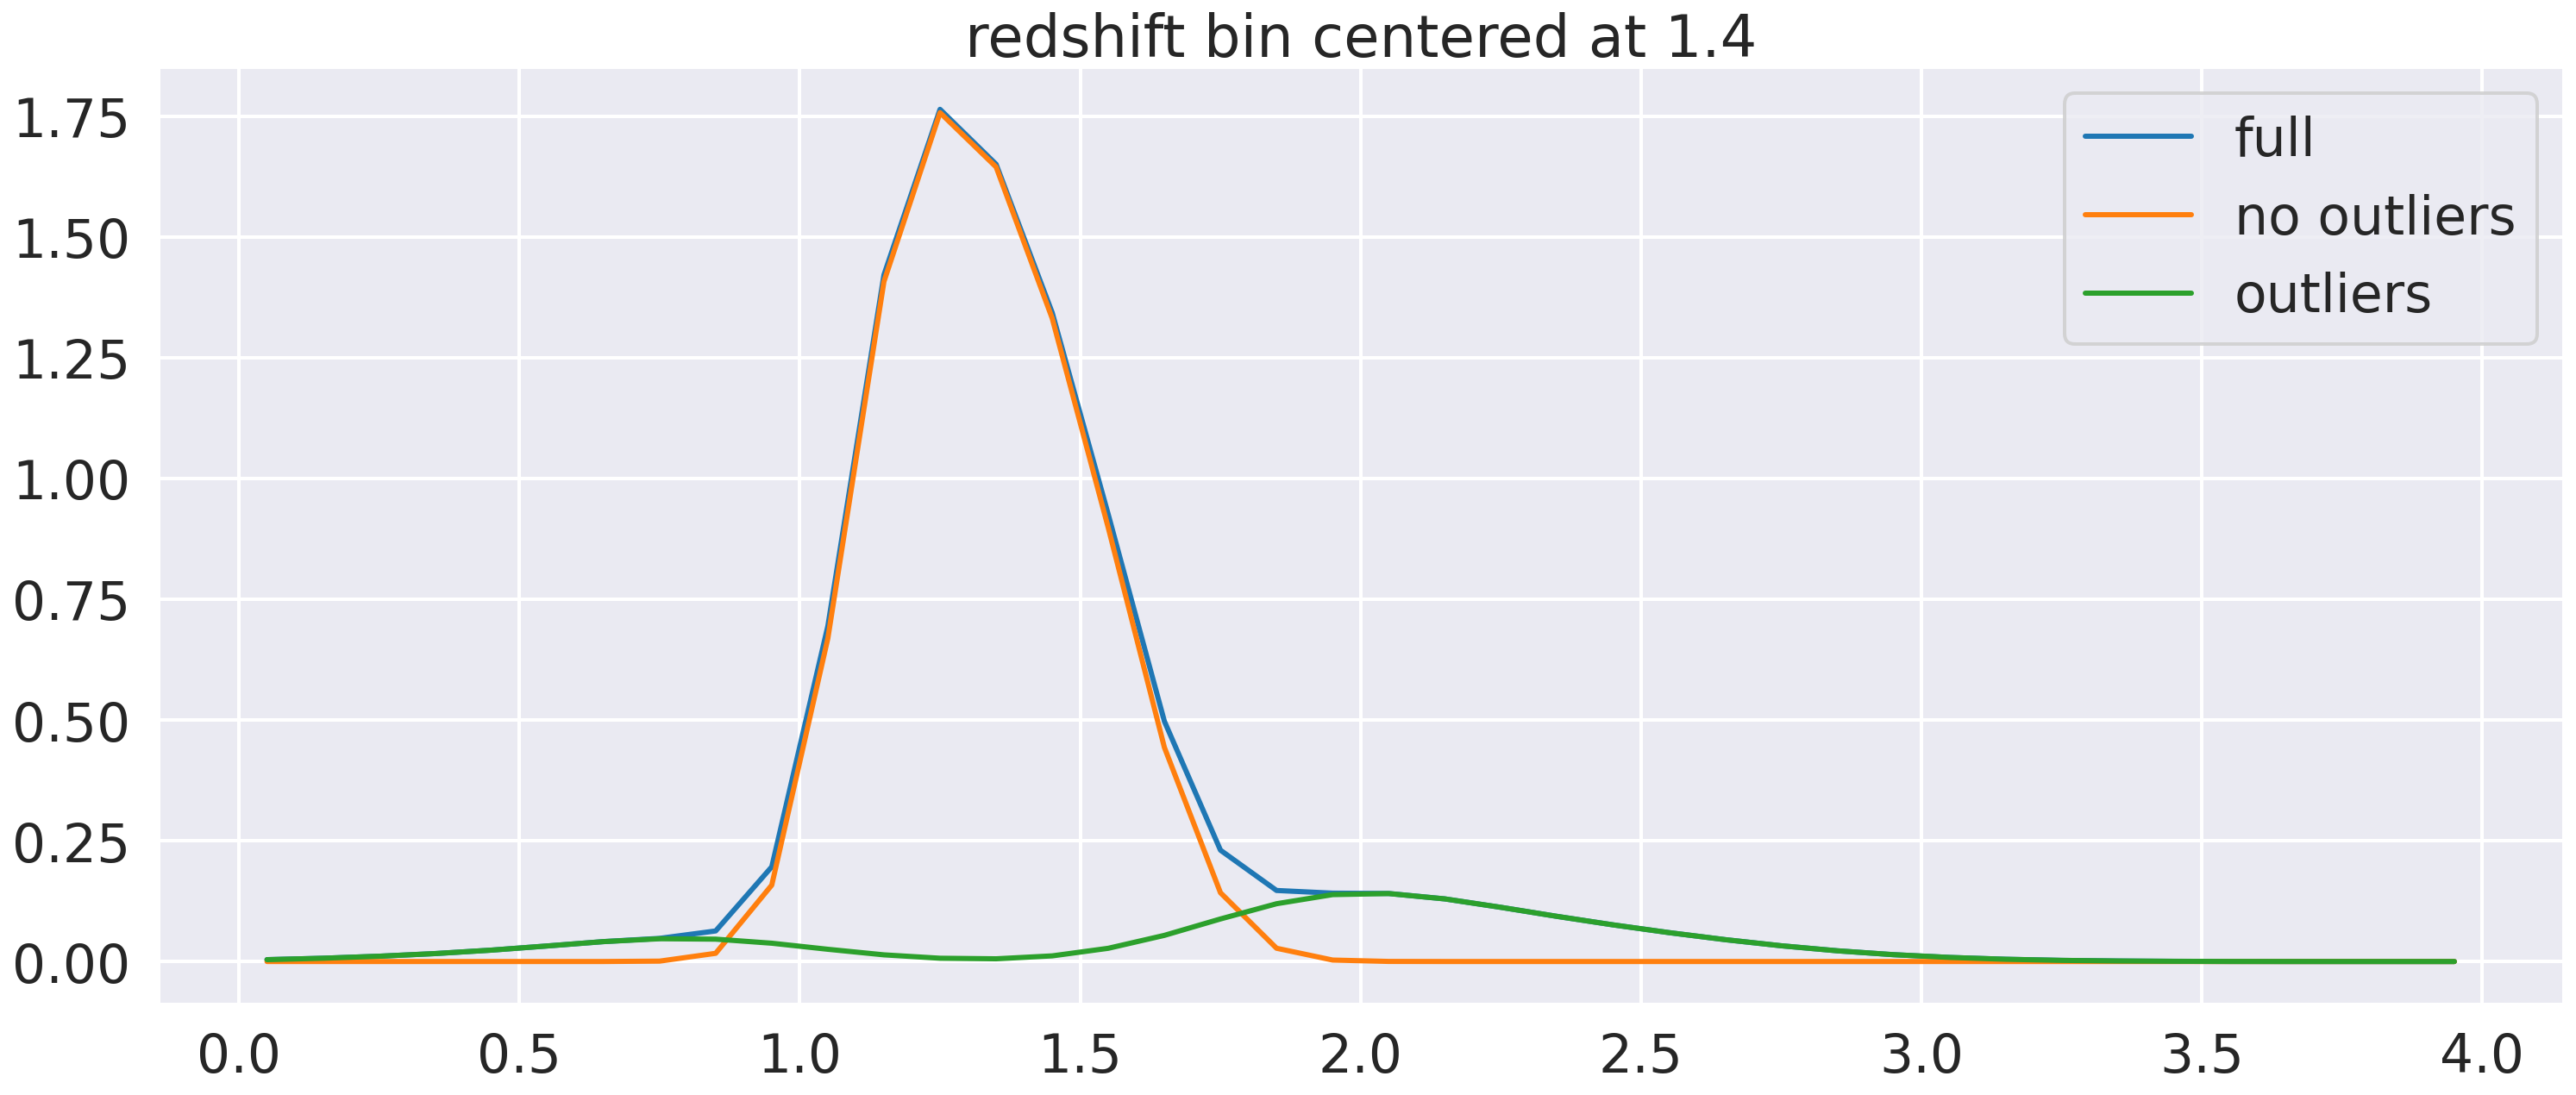

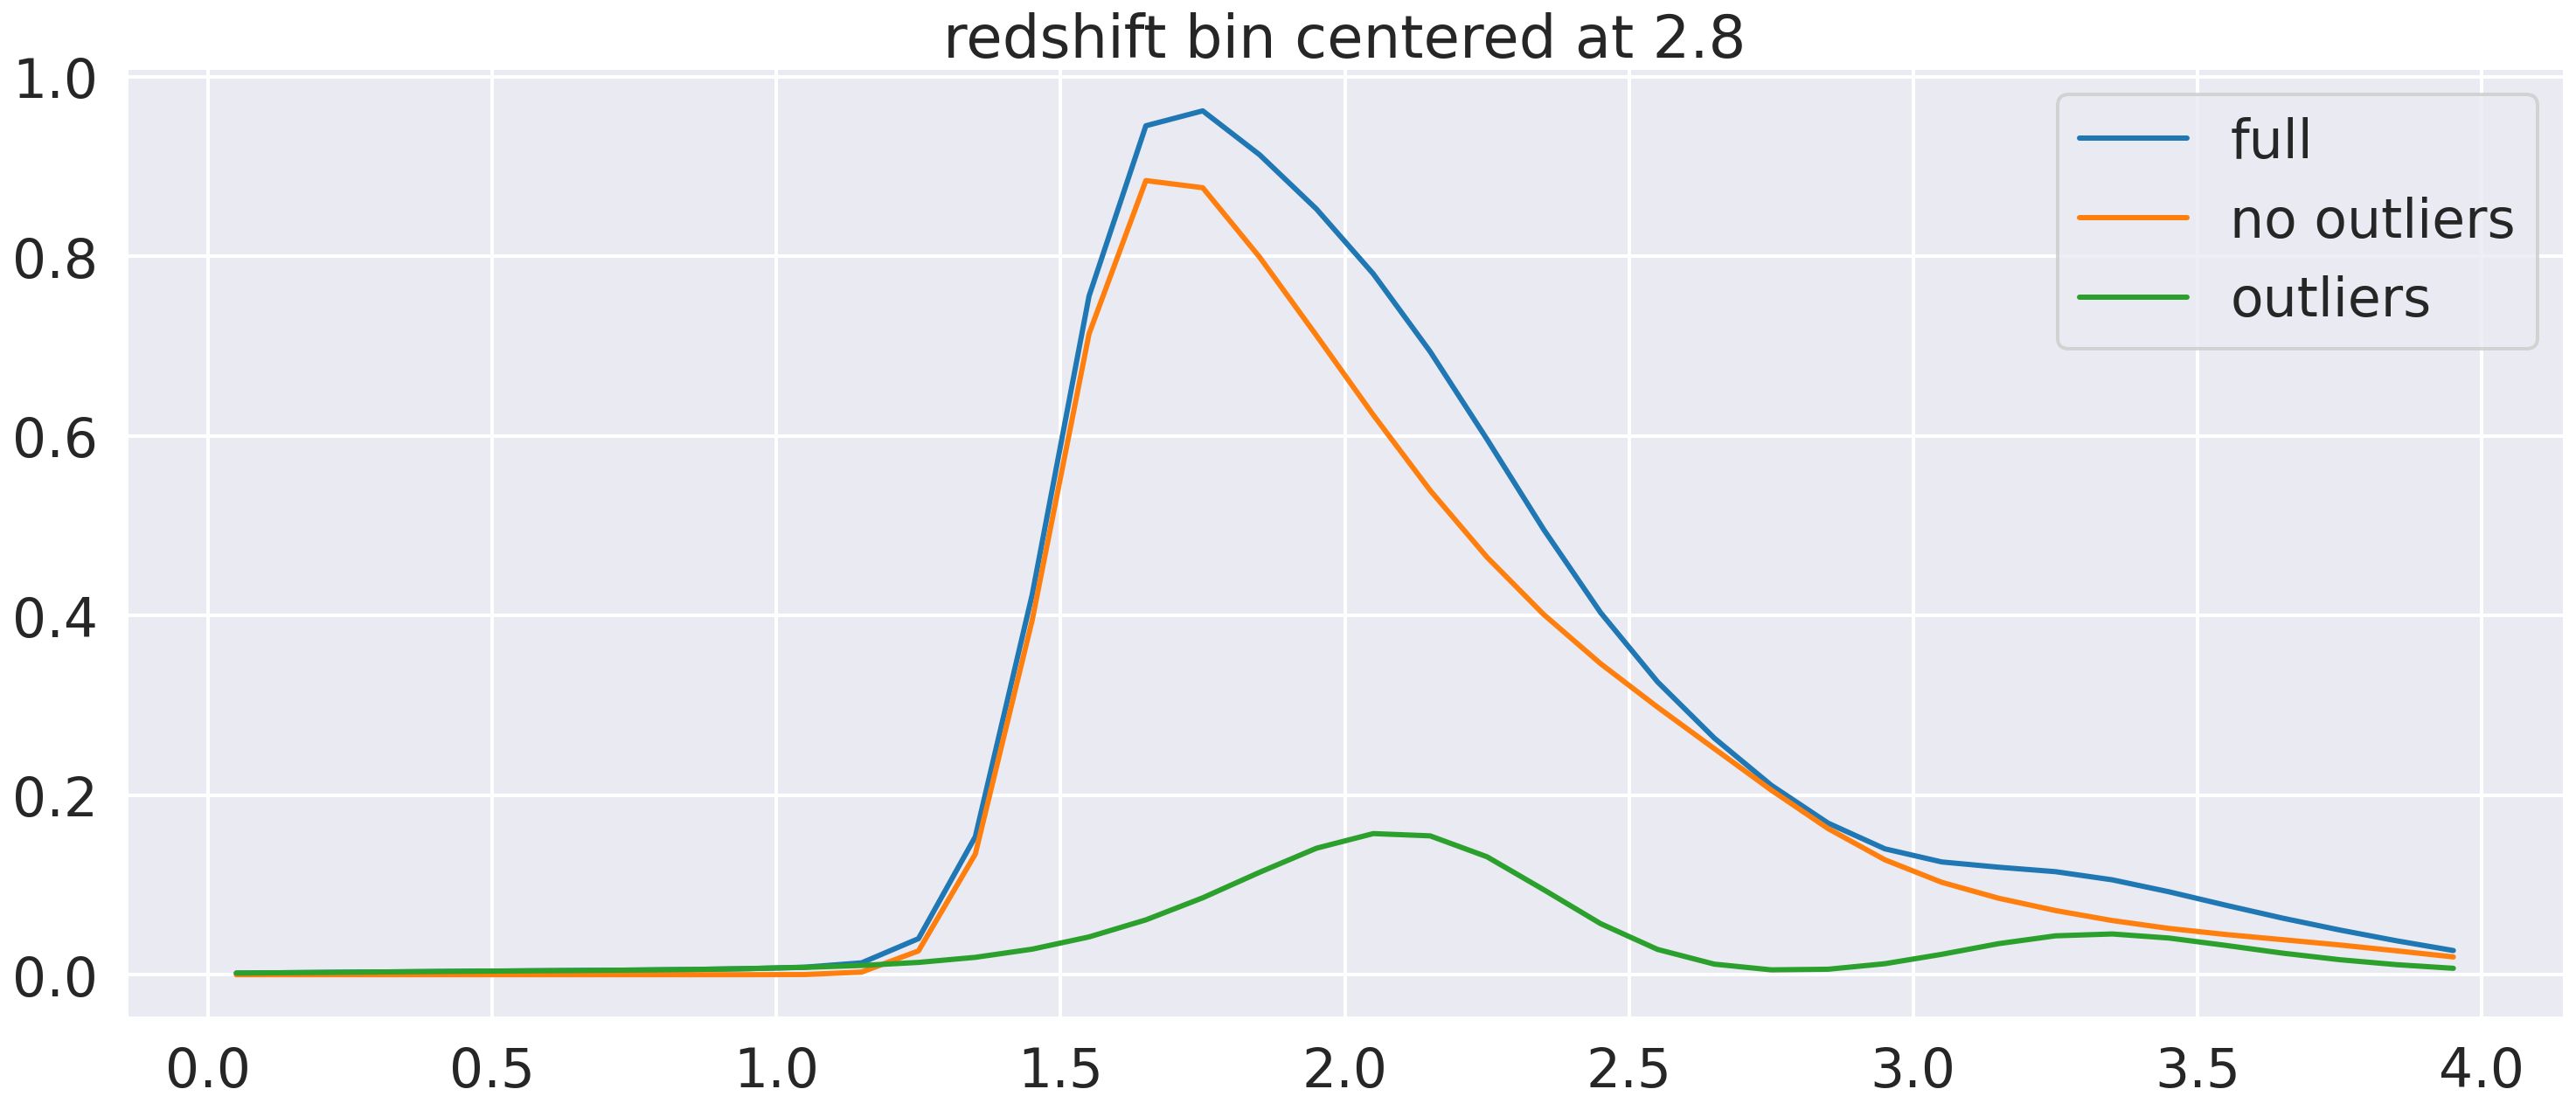

In [75]:
for i, key in enumerate(dNdz_dict_source.keys()):
    plt.figure()
    _ = sns.lineplot(x=obj.zmid, y=dNdz_dict_source[key], markers=False, label='full')
    _ = sns.lineplot(x=obj.zmid, y=copy[key]*0.85, markers=False, label='no outliers')
    _ = sns.lineplot(x=obj.zmid, y=scores[i]*0.15, markers=False, label='outliers')
    plt.title(f'redshift bin centered at {key:.1f}')
plt.legend()

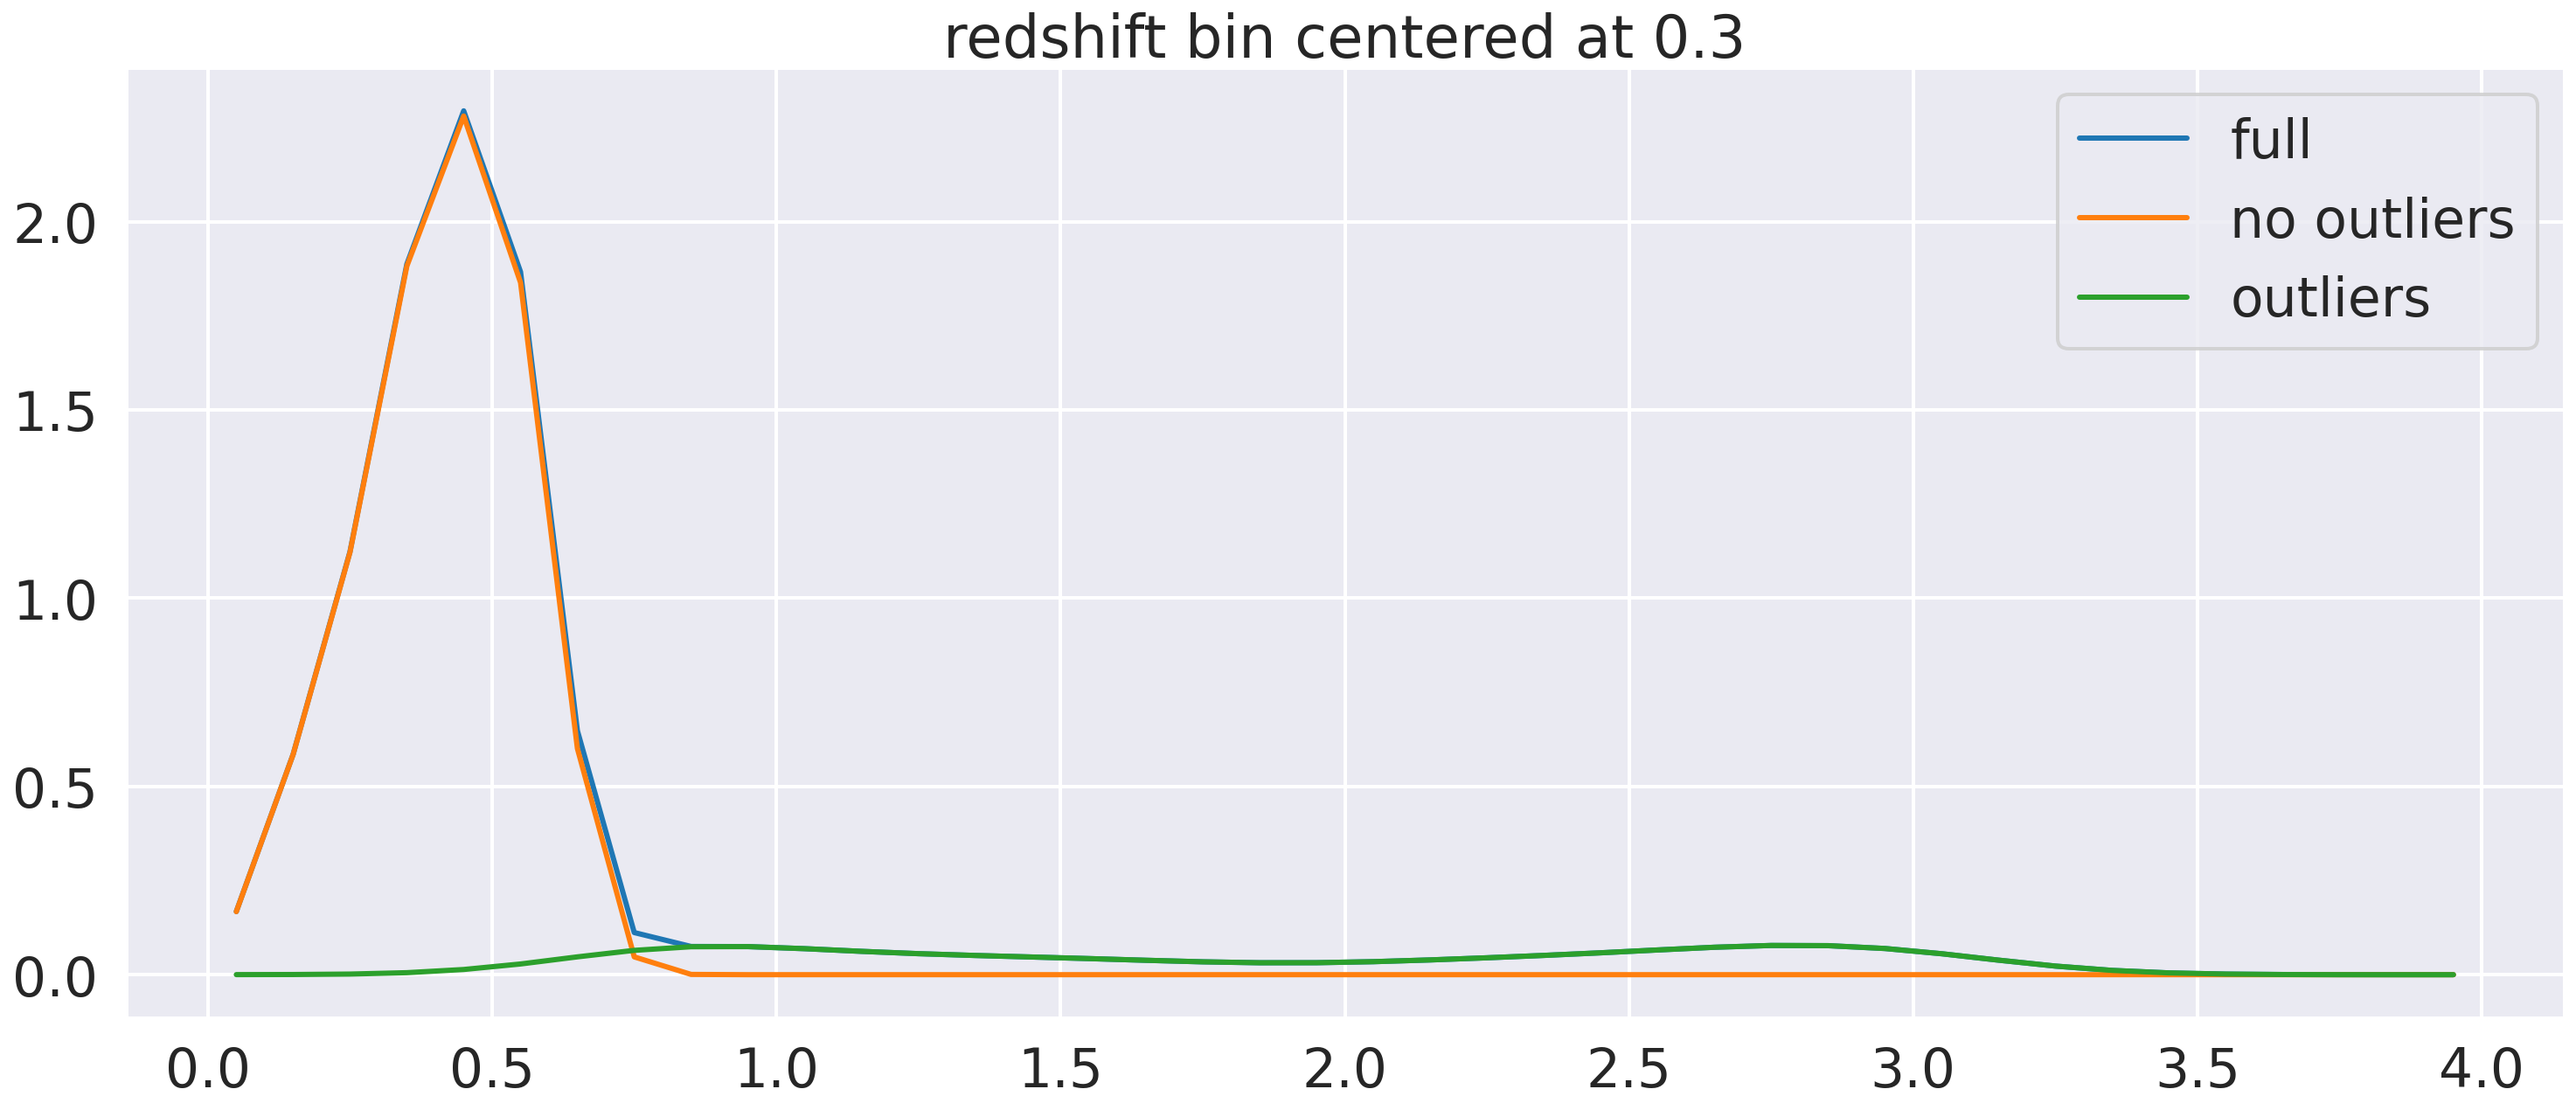

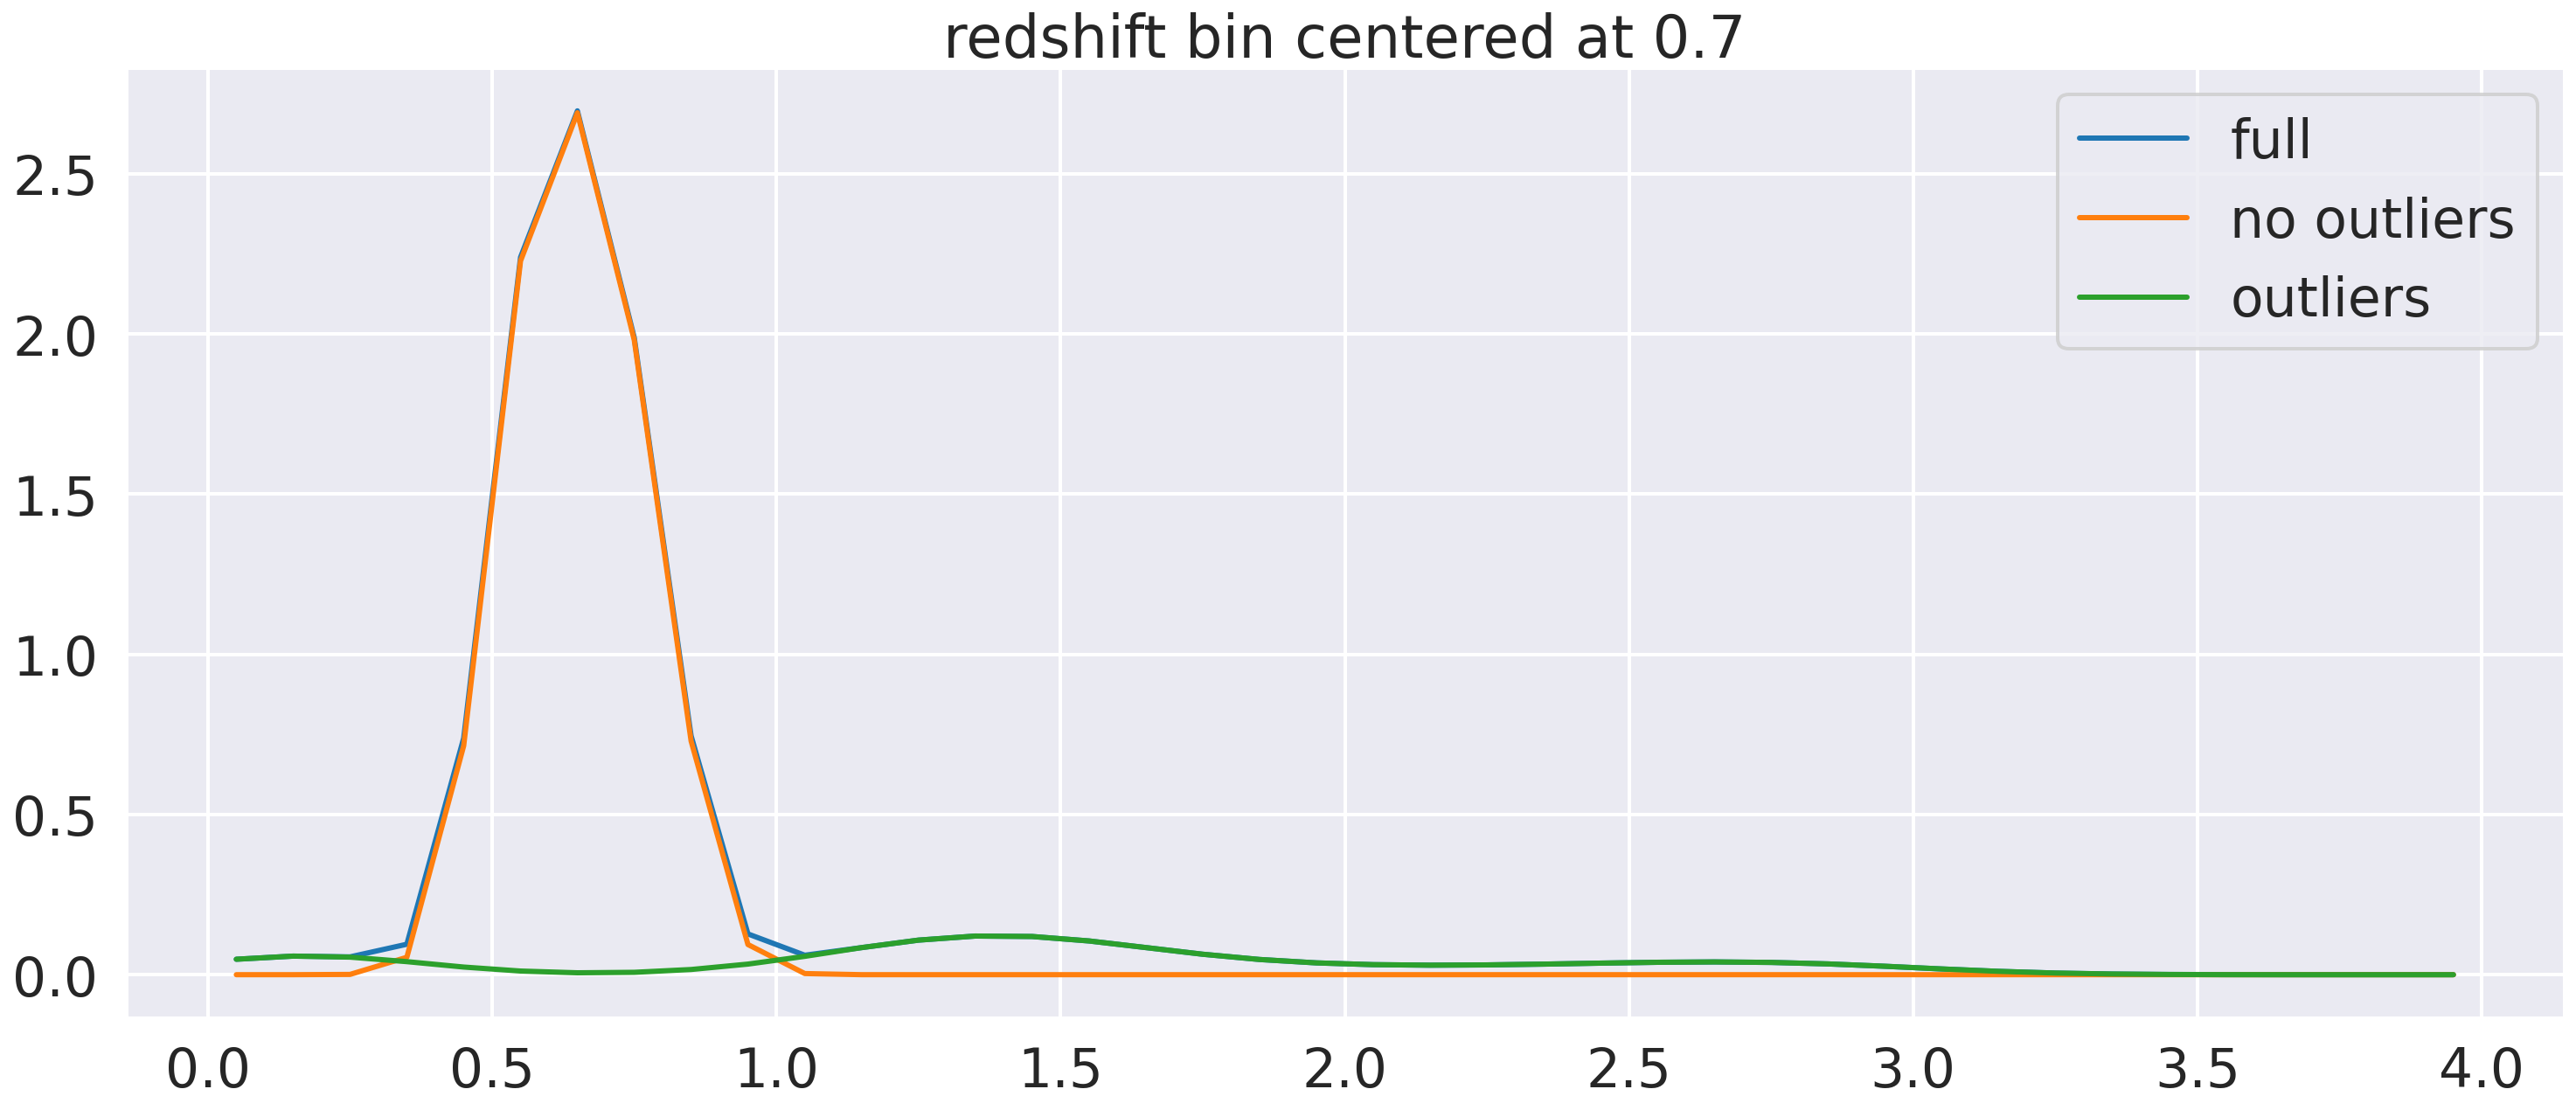

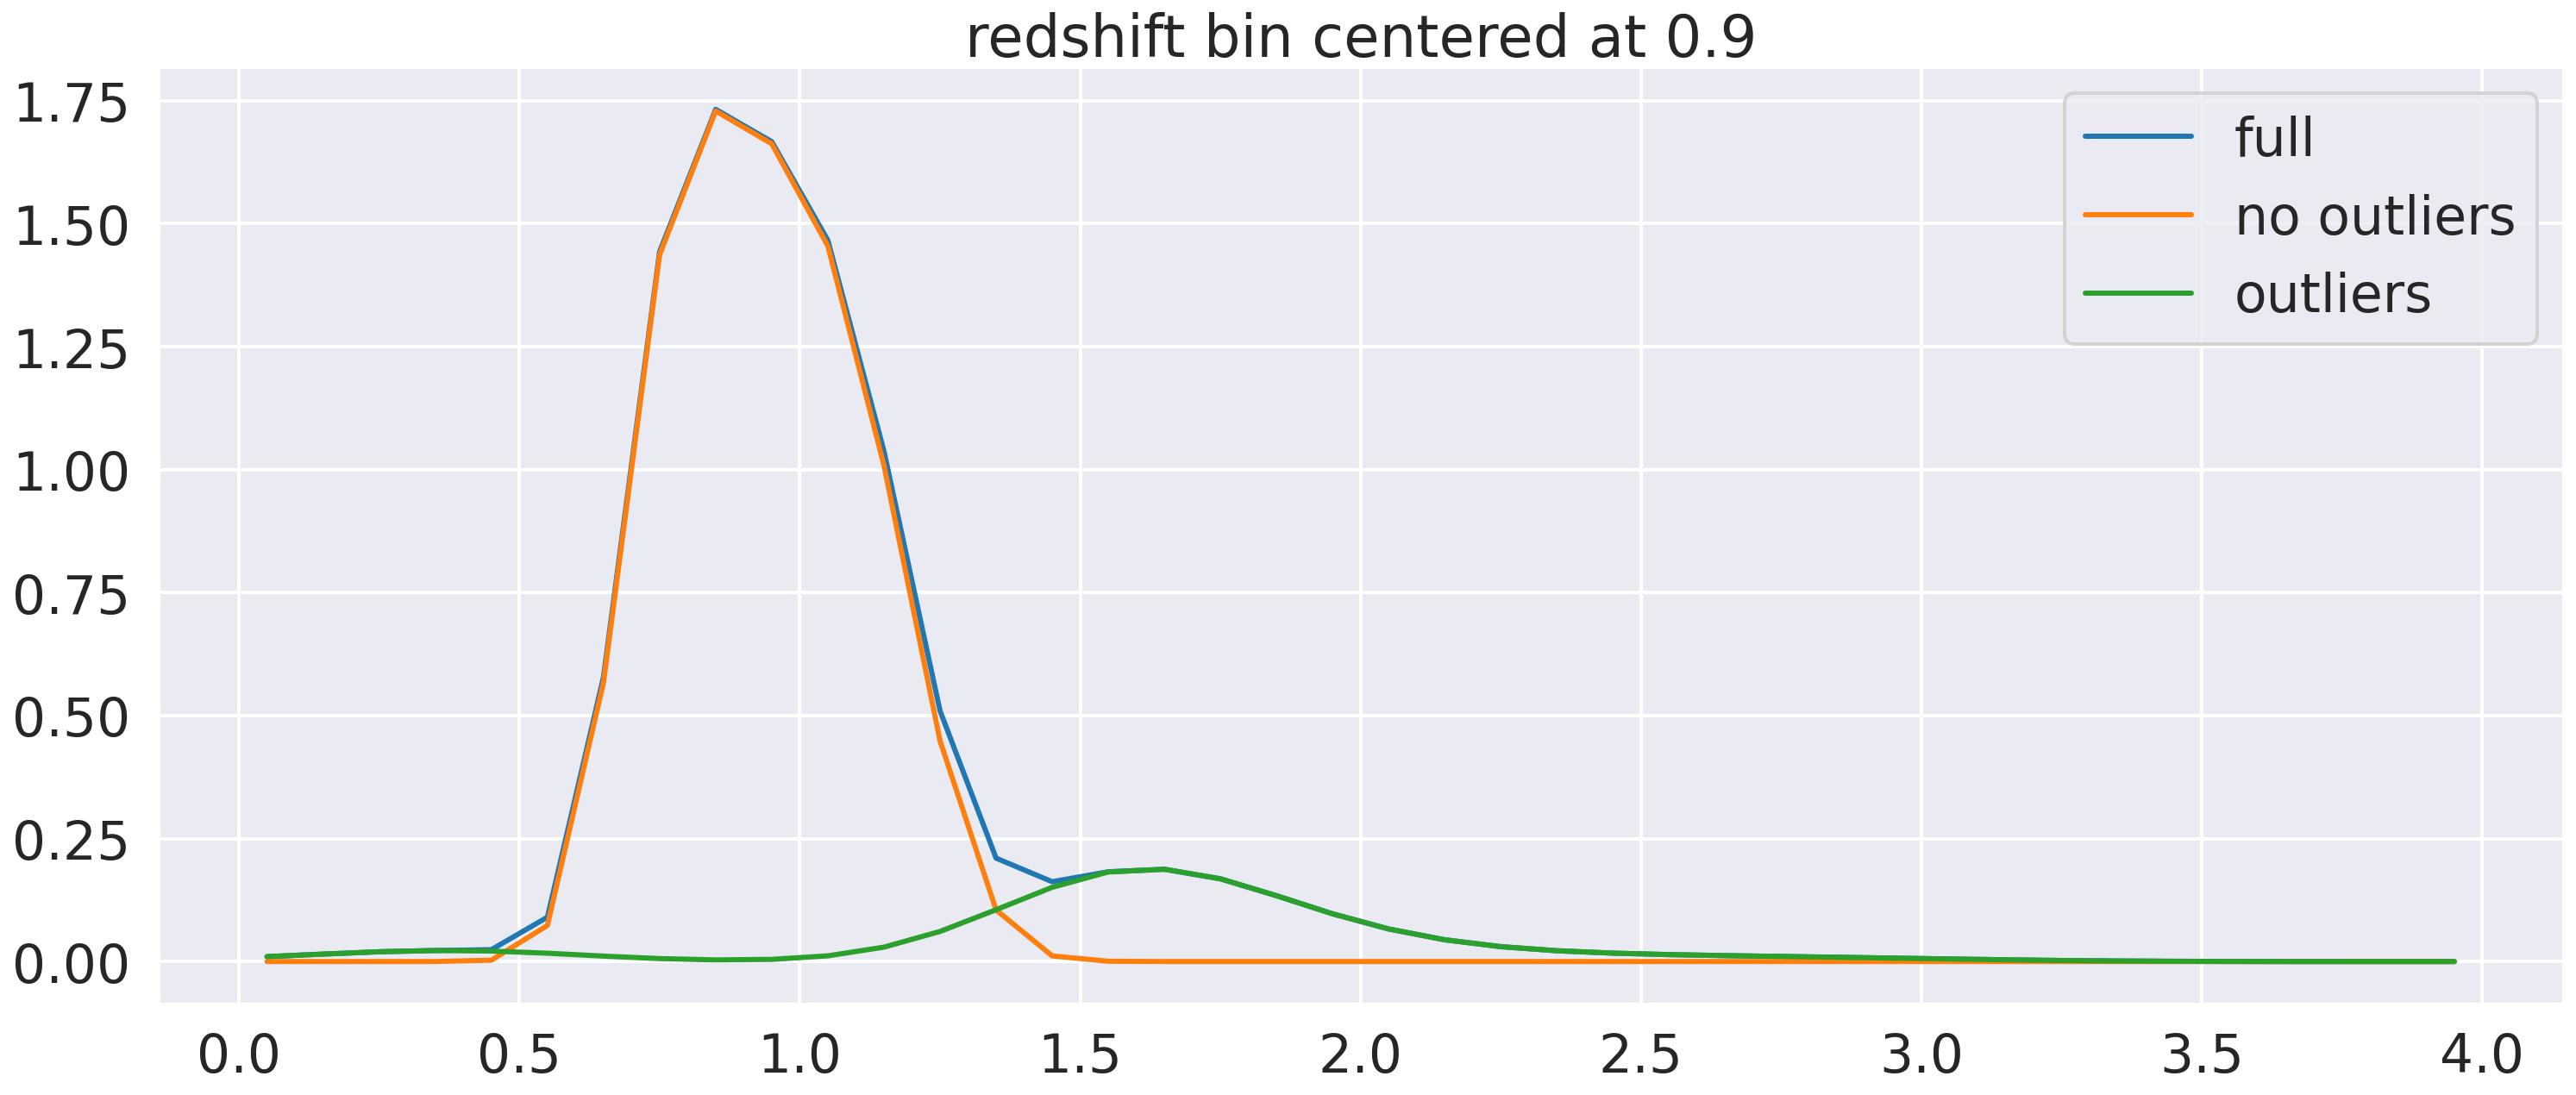

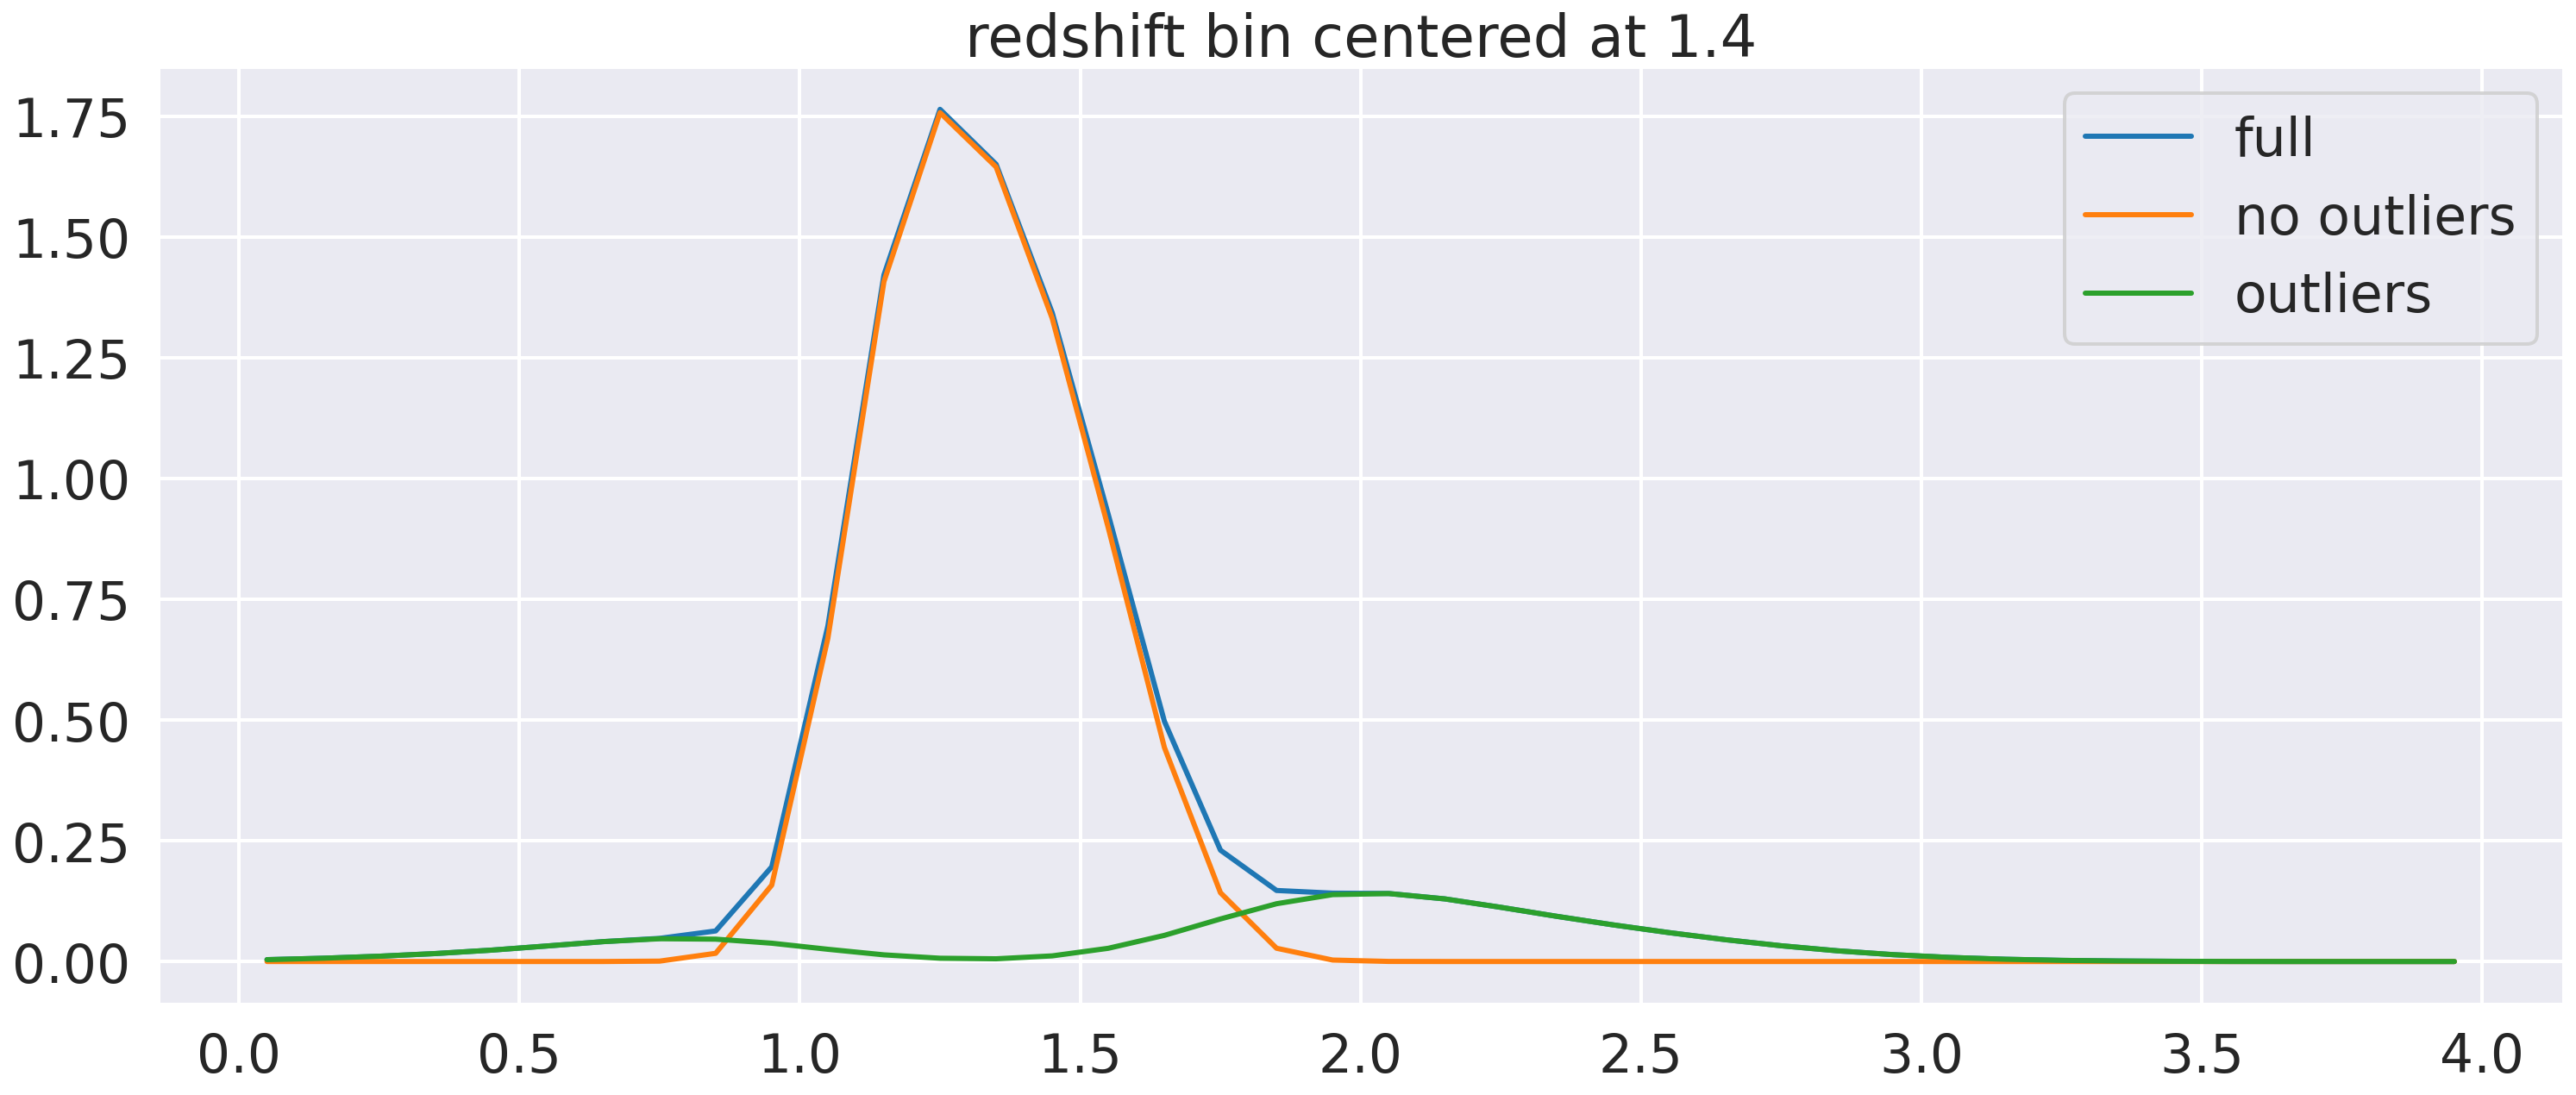

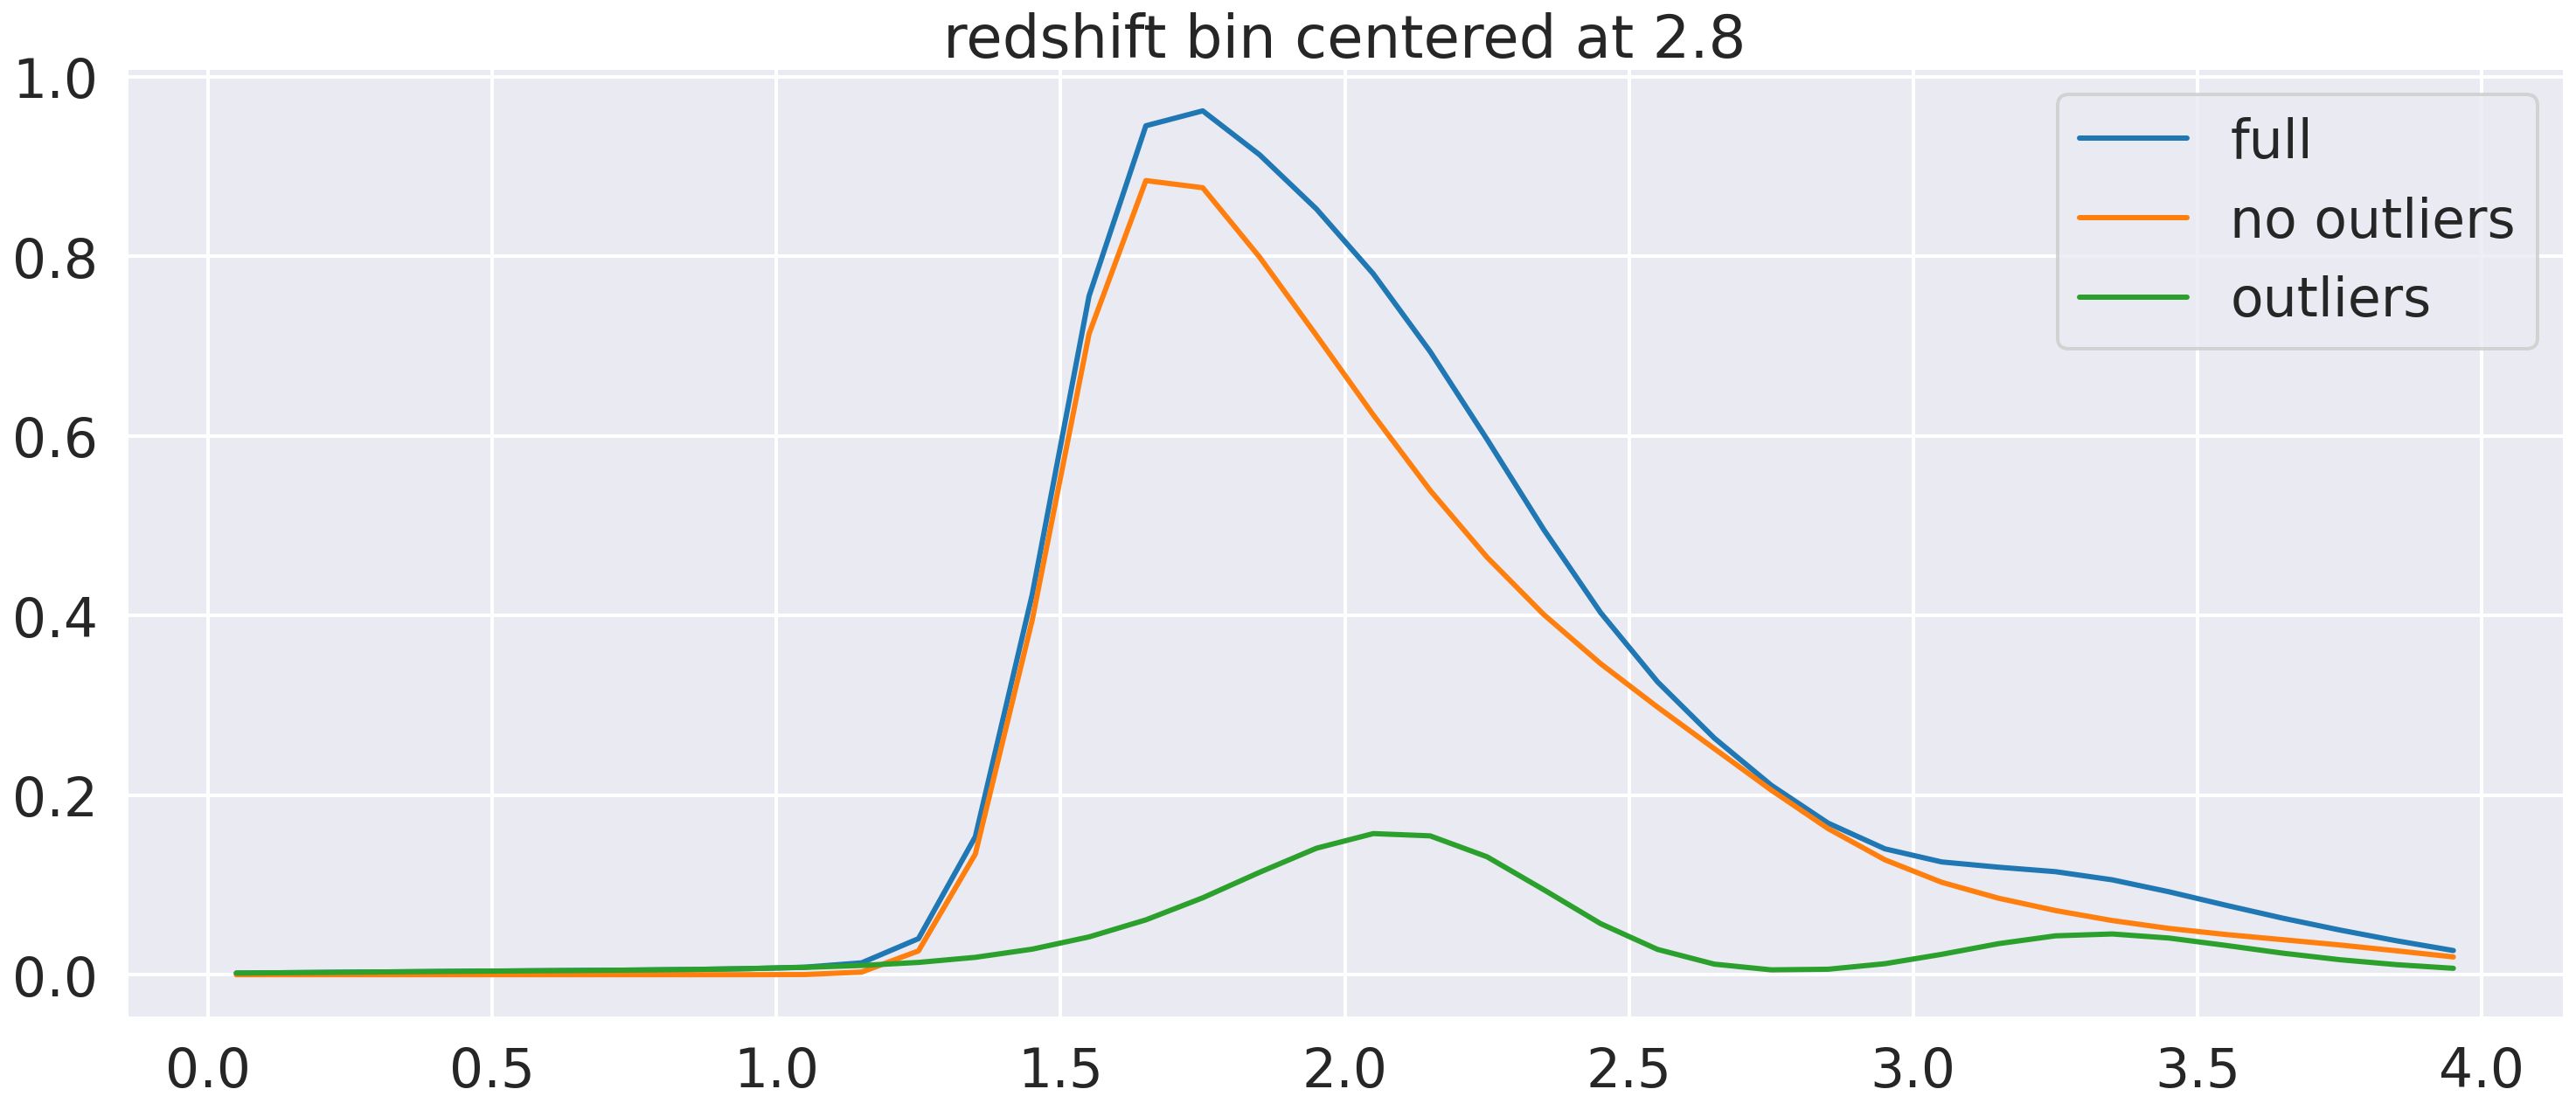

In [67]:
for i, key in enumerate(dNdz_dict_source.keys()):
    plt.figure()
    _ = sns.lineplot(x=obj.zmid, y=copy[key]*0.85 + scores[i]*0.15, markers=False, label='full')
    _ = sns.lineplot(x=obj.zmid, y=copy[key]*0.85, markers=False, label='no outliers')
    _ = sns.lineplot(x=obj.zmid, y=scores[i]*0.15, markers=False, label='outliers')
    plt.title(f'redshift bin centered at {key:.1f}')
plt.legend()